In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import pickle

In [3]:
from opt_einsum import contract

In [32]:
from coherence import *

In [42]:
from importlib import reload

import coherence
reload(coherence)
from coherence import *


In [25]:
%load_ext line_profiler

In [35]:
# L_list=np.arange(8,18,2)
L_list=np.arange(8,10,2)

In [37]:
# dirpath='Data/Bitstring'
# dirpath='/home/jake/Data/Bitstring'
dirpath='.'

In [38]:
f_0={}
for L in L_list:
    f_0[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf.hdf5'))

In [305]:
rho=get_rho_av(f_0,L=8,i=0)

In [308]:
torch.abs(rho).sum()

tensor(6.0450, dtype=torch.float64)

In [8]:
(np.abs(f_0[8]['wf_8'][0,0,0,...,:,0][...,0])**2).sum()

1.0000024017753415

In [ ]:
f_0[8]['wf_8'][0,0,0,...,:,0][...,0]

In [10]:
f_0[8].keys()

<KeysViewHDF5 ['wf_8']>

In [44]:
save_reduced_dm_swap(f_0,L=8,internal_coherence=True,)

100%|██████████| 21/21 [01:53<00:00,  5.40s/it]


In [59]:
save_reduced_dm(f_0,L=8,internal_coherence=True)

100%|██████████| 21/21 [00:00<00:00, 128.74it/s]


In [65]:
save_reduced_dm(f_0,L=10,internal_coherence=True)

100%|██████████| 21/21 [00:01<00:00, 20.46it/s]


In [66]:
save_reduced_dm(f_0,L=12,internal_coherence=True)

100%|██████████| 21/21 [00:07<00:00,  2.81it/s]


In [67]:
save_reduced_dm(f_0,L=14,internal_coherence=True)

100%|██████████| 21/21 [01:28<00:00,  4.22s/it]


In [ ]:
save_reduced_dm(f_0,L=16,internal_coherence=True)

In [11]:
wf=f_0[8][f'wf_{8}'][0,0,0,...,:,0]

In [115]:
wf.shape

(2, 2, 2, 2, 2, 2, 2, 2, 2000)

In [117]:
(2**16)**2*8/2**30

32.0

In [143]:
get_rho_av(f_0,8,0,s=0).shape

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

In [232]:
z=np.mean(np.array([get_reduced_dm(get_rho_av(f_0,8,0,s)) for s in range(2000)],),axis=0)


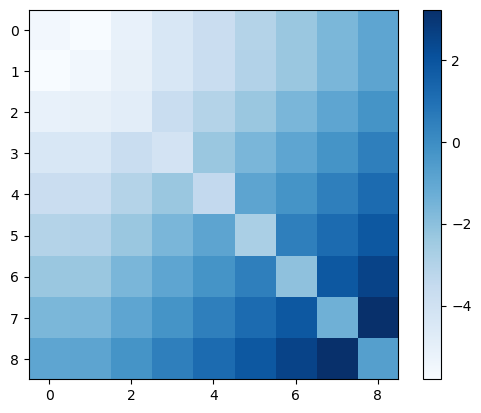

In [233]:
plt.imshow(np.log(z),cmap='Blues')
plt.colorbar()

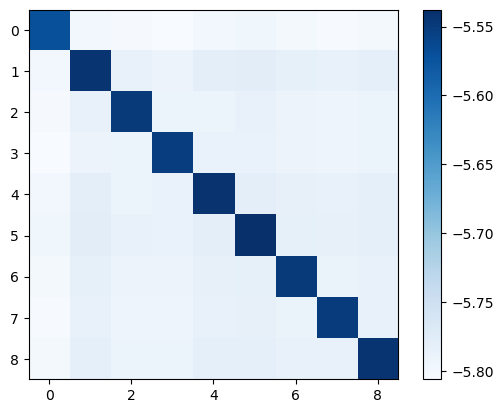

In [234]:
plt.imshow(np.log(get_reduced_dm_per_basis(z)),cmap='Blues',)
plt.colorbar()

In [136]:
z.shape

(2000, 5, 5)

In [ ]:
rho_av={L:get_rho_av(f_0,L,5) for L in [8,10,12,14]}

In [84]:
rho_av={L:get_rho_av(f_0,L,5) for L in [8,10,12,14]}

In [100]:
# rho_av=get_rho_av(f_0,8,10)

In [86]:
# red_dm=get_reduced_dm(rho_av)
red_dm={L:get_reduced_dm(rho_av[L]) for L in [8,10,12,14]}

In [87]:
# red_dm_per=get_reduce_dm_per_state(red_dm)
red_dm_per={L:get_reduce_dm_per_state(red_dm[L]) for L in [8,10,12,14]}

# Plot reduced density matrix

In [92]:
rho_av={}
L_list=[8,10,12,14,16]
for L in L_list:
    with open(f'rho_av_{L}.pickle','rb') as f:
        rho_av[L]=pickle.load(f)

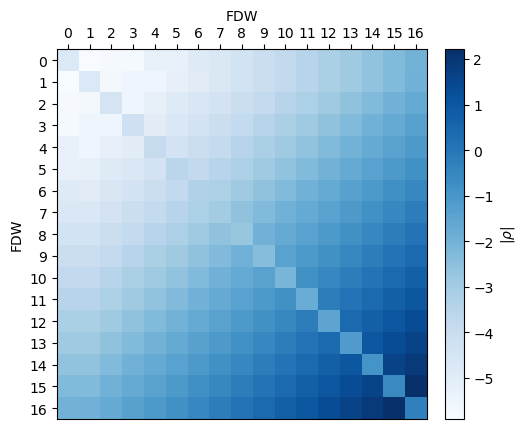

In [6]:
plot_reduced_dm(rho_av[16]['red_dm'][0])

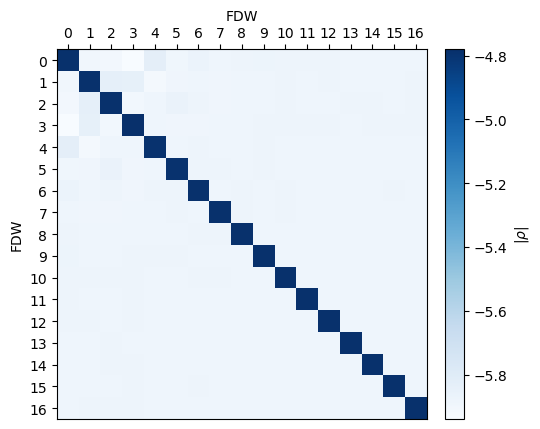

In [81]:
plot_reduced_dm(rho_av[16]['red_dm_per'][0])

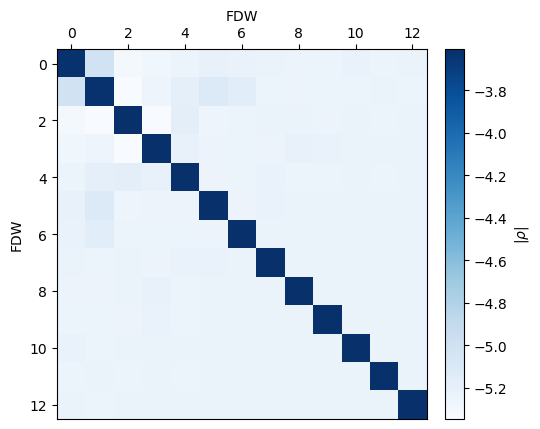

In [20]:
plot_reduced_dm(rho_av[12]['red_dm_per'][0])

# Fit coherence length and decay length

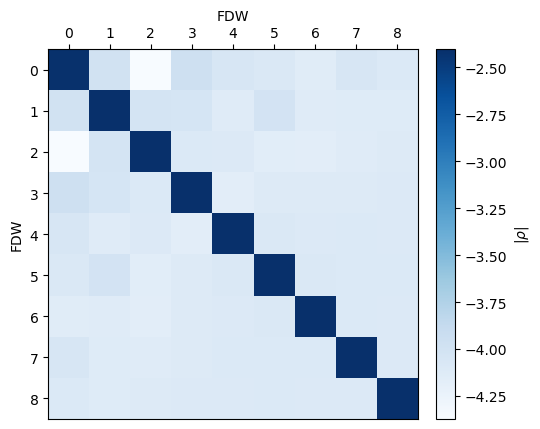

In [14]:
plot_reduced_dm(rho_av[8]['red_dm_per'][0])

In [94]:
def generate_fitting_data(rho_av,idx,idx_min=1):
    # idx=0
    L_list_=[]
    k_list_=[]
    C_list_=[]
    for L in (L_list):
        k_list=np.arange(idx_min,L+1)
        C=rho_av[L]['red_dm_per'][idx][0,idx_min:]

        L_list_.extend([L]*len(k_list))
        k_list_.extend(k_list)
        C_list_.extend(C)
        # ax.plot(k_list,,'.',label=f'L={L}',color=color)

    L_list_=np.array(L_list_)
    k_list_=np.array(k_list_)
    C_list_=np.array(C_list_)
    return k_list_,L_list_,C_list_

In [95]:
def remove_zero(k_list_,L_list_,C_list_,threshold=1e-10):
    mask= (C_list_>threshold)
    return k_list_[mask],L_list_[mask],C_list_[mask]

In [96]:
import statsmodels.api as sm


In [97]:
def linear_regression_2d(k, L, y):
    # Create the design matrix
    X = np.column_stack((L, k))
    X = sm.add_constant(X)  # Adds a constant term (A) to the model

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Extract the parameters and standard errors
    alpha, beta, A = model.params[1], model.params[2], model.params[0]
    alpha_err, beta_err, A_err = model.bse[1], model.bse[2], model.bse[0]

    return alpha, beta, A, alpha_err, beta_err, A_err

In [98]:
def fit_params(rho_av):
    alpha_list=[]
    beta_list=[]
    A_list=[]
    alpha_error_list=[]
    beta_error_list=[]
    A_error_list=[]

    for idx in range(20):
        k_list_,L_list_,C_list_=generate_fitting_data(rho_av,idx,idx_min=2)
        # print(k_list_.shape,L_list_.shape,C_list_.shape)
        k_list_,L_list_,C_list_=remove_zero(k_list_,L_list_,C_list_)
        try:
            alpha,beta,A,alpha_err, beta_err, A_err=linear_regression_2d(k_list_,L_list_,np.log2(C_list_))
        except:
            alpha,beta,A,alpha_err, beta_err, A_err=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
        alpha_list.append(alpha)
        beta_list.append(beta)
        A_list.append(A)
        alpha_error_list.append(alpha_err)
        beta_error_list.append(beta_err)
        A_error_list.append(A_err)
    return alpha_list,beta_list,A_list,alpha_error_list,beta_error_list,A_error_list,

In [99]:
alpha_list,beta_list,A_list,alpha_error_list,beta_error_list,A_error_list,=fit_params(rho_av)

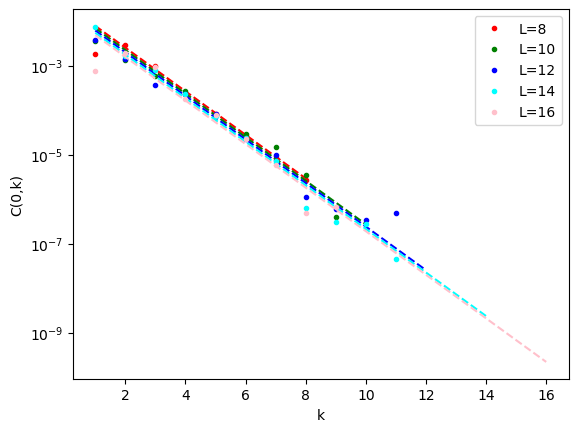

In [100]:
idx=14
color_list=['r','g','b','cyan','pink']
fig,ax=plt.subplots()
for L,color in zip(L_list,color_list):
    k_list=np.arange(1,L+1)
    ax.plot(k_list,rho_av[L]['red_dm_per'][idx][0,1:],'.',label=f'L={L}',color=color)

    ax.plot(k_list,np.exp2(A_list[idx])*np.exp2(alpha_list[idx]*L)*np.exp2(k_list*beta_list[idx]),'--',color=color)
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel('C(0,k)')
ax.set_yscale('log')

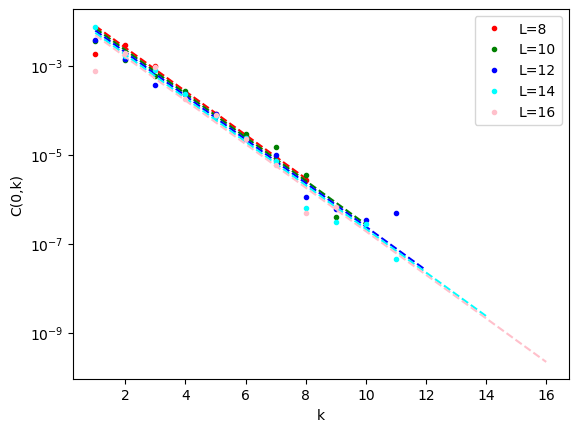

In [23]:
idx=14
color_list=['r','g','b','cyan','pink']
fig,ax=plt.subplots()
for L,color in zip(L_list,color_list):
    k_list=np.arange(1,L+1)
    ax.plot(k_list,rho_av[L]['red_dm_per'][idx][0,1:],'.',label=f'L={L}',color=color)

    ax.plot(k_list,np.exp(A_list[idx])*np.exp(alpha_list[idx]*L)*np.exp(k_list*beta_list[idx]),'--',color=color)
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel('C(0,k)')
ax.set_yscale('log')

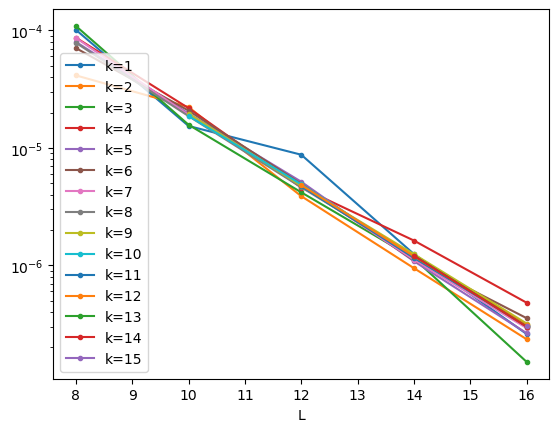

In [27]:
idx=0
C_list_k={}
L_list_k={}
for k in range(1,L_list[-1]):
    C_list_=[]
    L_list_=[]
    for L in L_list:
        try:
            C_list_.append(rho_av[L]['red_dm_per'][idx][0,k])
            L_list_.append(L)
        except:
            pass

    plt.plot(L_list_,C_list_,'.-',label=f'k={k}',)
    C_list_k[k]=C_list_
    L_list_k[k]=L_list_
plt.legend()
plt.xlabel('L')
plt.yscale('log')

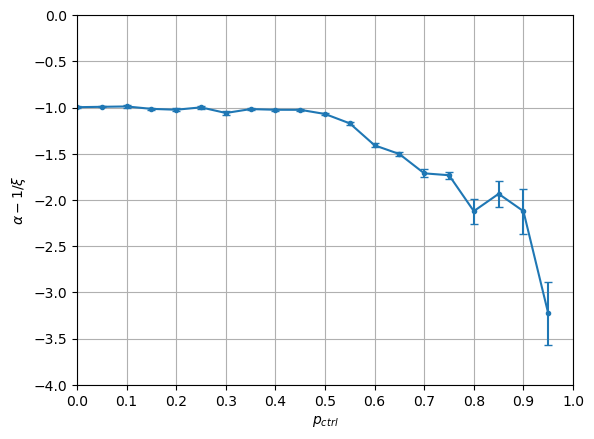

In [102]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(beta_list)],np.array(beta_list)+np.array(alpha_list),yerr=beta_error_list,fmt='.-',capsize=3)

# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\alpha-1/\xi$')
ax.set_xlim(0,1)
ax.set_ylim(-4,0)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

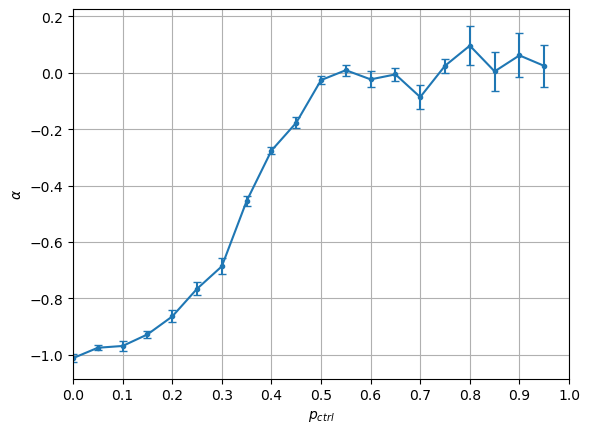

In [103]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(alpha_list)],alpha_list,yerr=alpha_error_list,fmt='.-',capsize=3)

ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0,1)
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

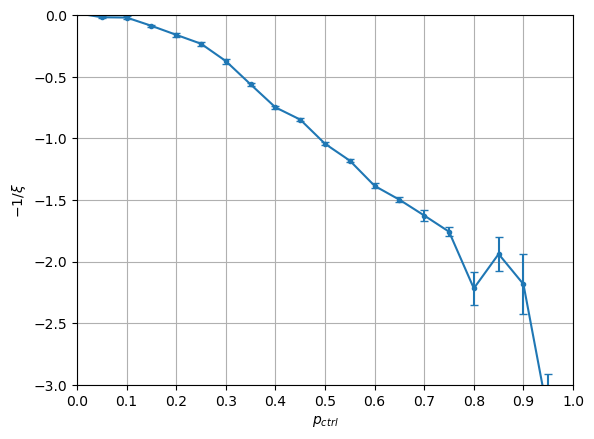

In [104]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(beta_list)],beta_list,yerr=beta_error_list,fmt='.-',capsize=3)
# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$-1/\xi$')
ax.set_xlim(0,1)
ax.set_ylim(-3,0)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

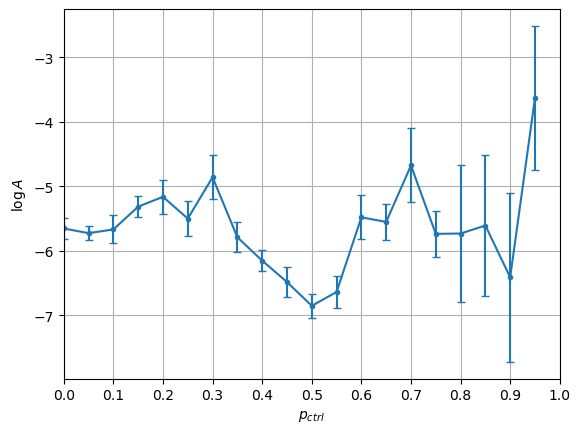

In [105]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(A_list)],A_list,yerr=A_error_list,fmt='.-',capsize=3)

# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\log A$')
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

## Diagonal

In [106]:
def generate_fitting_data_diag(rho_av,idx,idx_min=1):
    # idx=0
    L_list_=[]
    k_list_=[]
    C_list_=[]
    for L in (L_list):
        k_list=np.arange(idx_min,L+1)
        C=np.diag(rho_av[L]['red_dm_per'][idx])

        L_list_.extend([L]*len(k_list))
        k_list_.extend(k_list)
        C_list_.extend(C)
        # ax.plot(k_list,,'.',label=f'L={L}',color=color)

    L_list_=np.array(L_list_)
    k_list_=np.array(k_list_)
    C_list_=np.array(C_list_)
    return k_list_,L_list_,C_list_

In [107]:
def fit_params_diag(rho_av):
    alpha_list=[]
    beta_list=[]
    A_list=[]
    alpha_error_list=[]
    beta_error_list=[]
    A_error_list=[]

    for idx in range(20):
        k_list_,L_list_,C_list_=generate_fitting_data_diag(rho_av,idx,idx_min=0)
        # print(k_list_.shape,L_list_.shape,C_list_.shape)
        k_list_,L_list_,C_list_=remove_zero(k_list_,L_list_,C_list_)
        try:
            alpha,beta,A,alpha_err, beta_err, A_err=linear_regression_2d(k_list_,L_list_,np.log2(C_list_))
        except:
            alpha,beta,A,alpha_err, beta_err, A_err=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
        alpha_list.append(alpha)
        beta_list.append(beta)
        A_list.append(A)
        alpha_error_list.append(alpha_err)
        beta_error_list.append(beta_err)
        A_error_list.append(A_err)
    return alpha_list,beta_list,A_list,alpha_error_list,beta_error_list,A_error_list,

In [109]:
alpha_diag_list,beta_diag_list,A_diag_list,alpha_error_diag_list,beta_error_diag_list,A_error_diag_list,=fit_params_diag(rho_av)

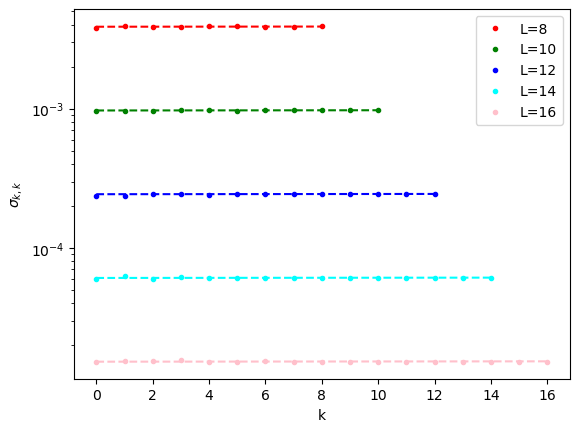

In [110]:
idx=0
color_list=['r','g','b','cyan','pink']
fig,ax=plt.subplots()
for L,color in zip(L_list,color_list):
    k_list=np.arange(0,L+1)
    ax.plot(k_list,np.diag(rho_av[L]['red_dm_per'][idx]),'.',label=f'L={L}',color=color)

    ax.plot(k_list,np.exp2(A_diag_list[idx])*np.exp2(alpha_diag_list[idx]*L)*np.exp2(k_list*beta_diag_list[idx]),'--',color=color)
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel('$\sigma_{k,k}$')
ax.set_yscale('log')

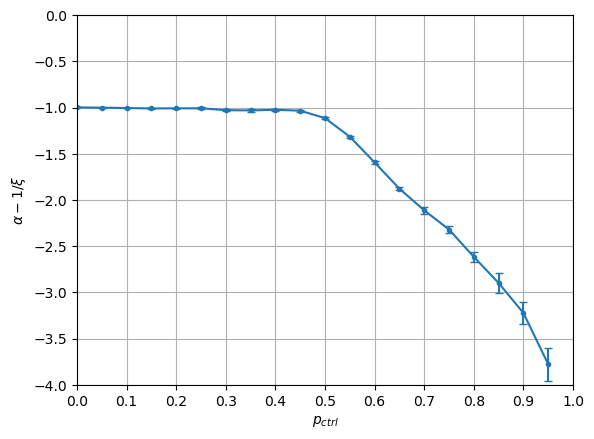

In [111]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(beta_list)],np.array(beta_diag_list)+np.array(alpha_diag_list),yerr=beta_error_diag_list,fmt='.-',capsize=3)

# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\alpha-1/\xi$')
ax.set_xlim(0,1)
ax.set_ylim(-4,0)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

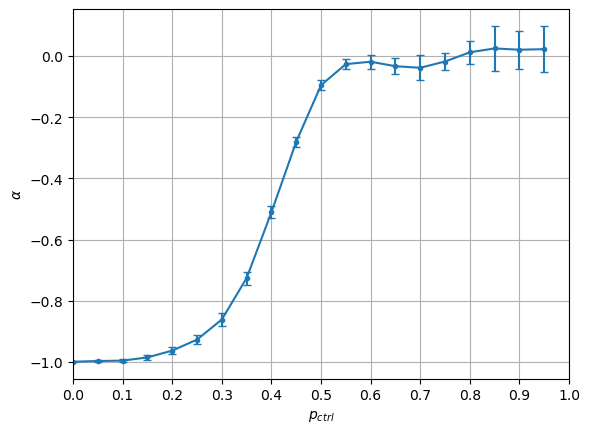

In [112]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(alpha_diag_list)],alpha_diag_list,yerr=alpha_error_diag_list,fmt='.-',capsize=3)

ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0,1)
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

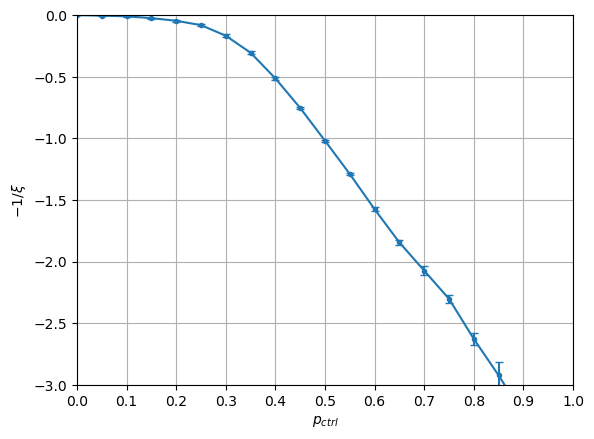

In [113]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(beta_list)],beta_diag_list,yerr=beta_error_diag_list,fmt='.-',capsize=3)

# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$-1/\xi$')
ax.set_xlim(0,1)
ax.set_ylim(-3,0)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

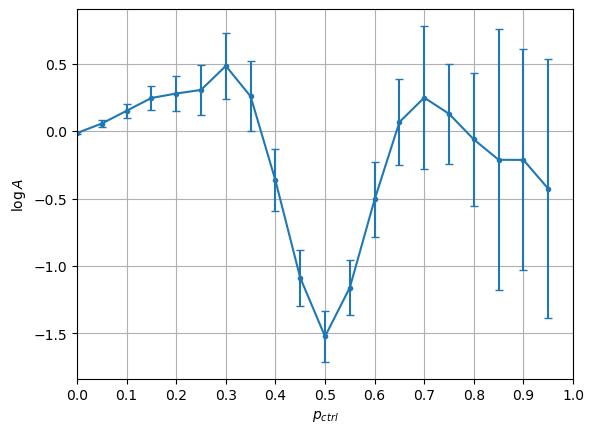

In [114]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(A_list)],A_diag_list,yerr=A_error_diag_list,fmt='.-',capsize=3)

# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\log A$')
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

# Plot reduced density matrix (swap order of C and p_m)

In [131]:
C_av={}
L_list=[8,10,12,]
for L in L_list:
    with open(f'C_av_{L}.pickle','rb') as f:
    # with open(f'C_av_{L}_internal.pickle','rb') as f:
        C_av[L]=pickle.load(f)

## Diagonal same

In [337]:
np.allclose(np.einsum(C_av[8]['red_dm']-rho_av[8]['red_dm'],[0,1,1],[0,1]),0)

True

In [338]:
np.allclose(np.einsum(C_av[10]['red_dm']-rho_av[10]['red_dm'],[0,1,1],[0,1]),0)

True

In [339]:
np.allclose(np.einsum(C_av[12]['red_dm']-rho_av[12]['red_dm'],[0,1,1],[0,1]),0)

True

## Off-diagonal as upper bound

In [28]:
(C_av[8]['red_dm_per']-rho_av[8]['red_dm_per']).min()

-6.938893903907228e-17

In [29]:
(C_av[10]['red_dm_per']-rho_av[10]['red_dm_per']).min()

-6.245004513516506e-17

In [329]:
(C_av[12]['red_dm_per']-rho_av[12]['red_dm_per']).min()

-1.1102230246251565e-16

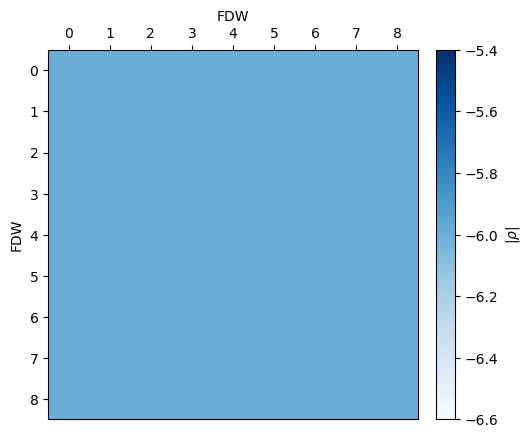

In [53]:
plot_reduced_dm(C_av[8]['red_dm'][20])

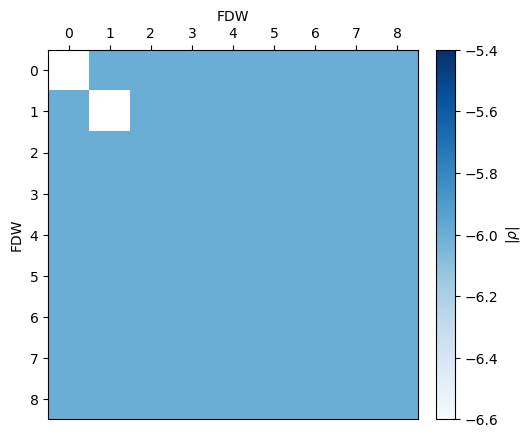

In [57]:
plot_reduced_dm(C_av[8]['red_dm_per'][20])

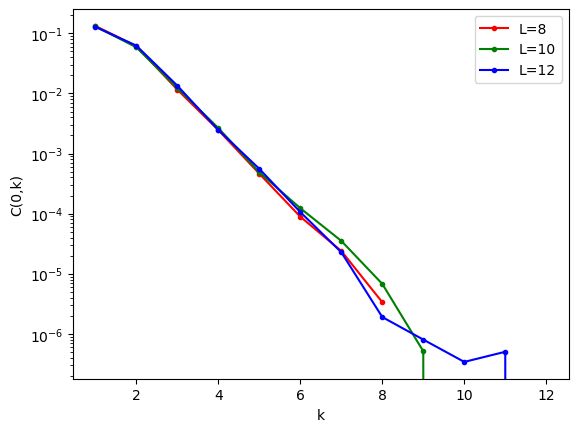

In [30]:
idx=14
color_list=['r','g','b','cyan','pink']
fig,ax=plt.subplots()
for L,color in zip(L_list,color_list):
    k_list=np.arange(1,L+1)
    ax.plot(k_list,C_av[L]['red_dm_per'][idx][0,1:],'.-',label=f'L={L}',color=color)

    # ax.plot(k_list,np.exp(A_list[idx])*np.exp(alpha_list[idx]*L)*np.exp(k_list*beta_list[idx]),'--',color=color)
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel('C(0,k)')
ax.set_yscale('log')

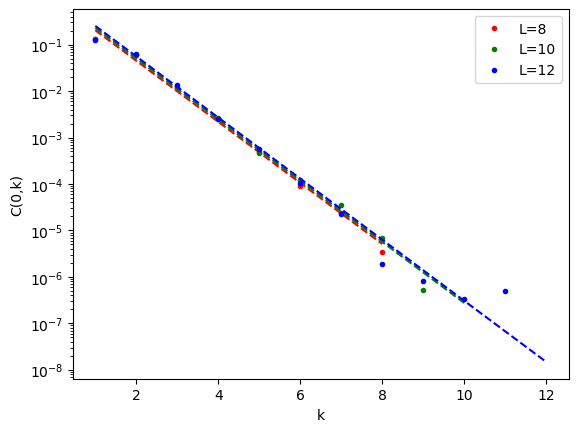

In [33]:
idx=14
color_list=['r','g','b','cyan','pink']
fig,ax=plt.subplots()
for L,color in zip(L_list,color_list):
    k_list=np.arange(1,L+1)
    ax.plot(k_list,C_av[L]['red_dm_per'][idx][0,1:],'.',label=f'L={L}',color=color)

    ax.plot(k_list,np.exp(A_C_list[idx])*np.exp(alpha_C_list[idx]*L)*np.exp(k_list*beta_C_list[idx]),'--',color=color)
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel('C(0,k)')
ax.set_yscale('log')

In [333]:
np.einsum(C_av[8]['red_dm'],[0,1,1],[0,1])

(21, 9)

In [132]:
alpha_C_list,beta_C_list,A_C_list,alpha_error_C_list,beta_error_C_list,A_error_C_list,=fit_params(C_av)

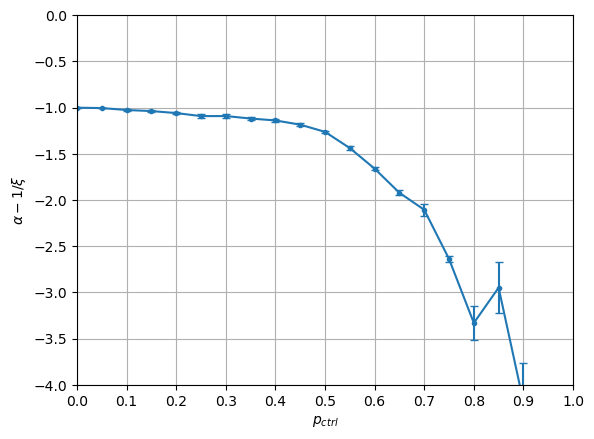

In [133]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(beta_list)],np.array(beta_C_list)+np.array(alpha_C_list),yerr=beta_error_C_list,fmt='.-',capsize=3)

# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\alpha-1/\xi$')
ax.set_xlim(0,1)
ax.set_ylim(-4,0)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

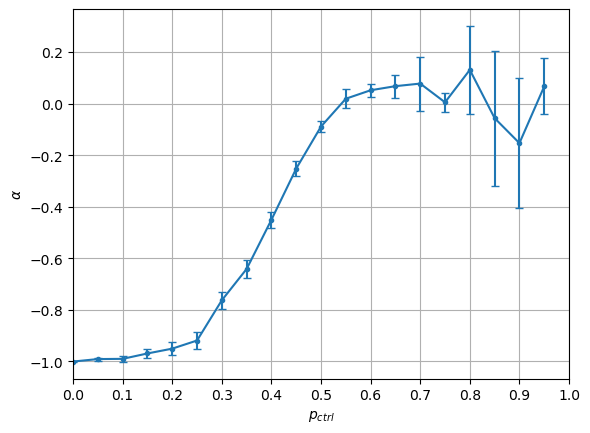

In [150]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(alpha_C_list)],alpha_C_list,yerr=alpha_error_C_list,fmt='.-',capsize=3)

ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0,1)
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

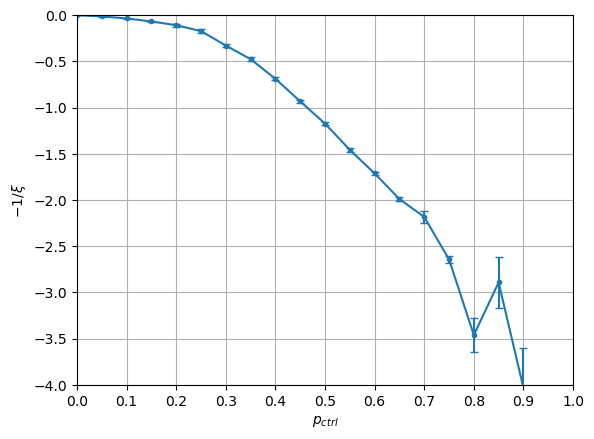

In [152]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(beta_list)],beta_C_list,yerr=beta_error_C_list,fmt='.-',capsize=3)

# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$-1/\xi$')
ax.set_xlim(0,1)
ax.set_ylim(-4,0)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

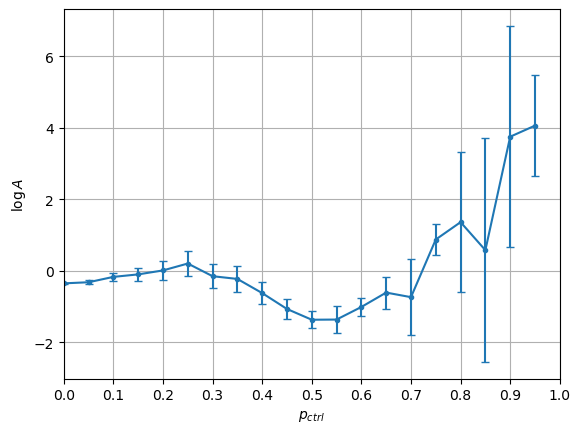

In [153]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(A_list)],A_C_list,yerr=A_error_C_list,fmt='.-',capsize=3)

# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\log A$')
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

# Summary of three curves

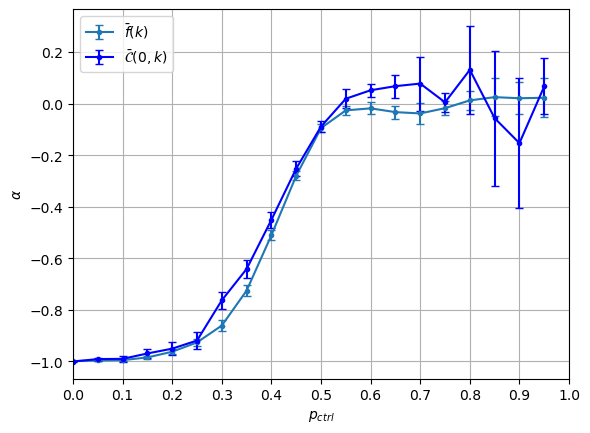

In [134]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(alpha_diag_list)],alpha_diag_list,yerr=alpha_error_diag_list,fmt='.-',capsize=3,label=r'$\bar{f}(k)$')

# ax.errorbar(p_ctrl_list[:len(alpha_list)],alpha_list,yerr=alpha_error_list,fmt='.-',capsize=3,color='r',label=r'$C(0,k)$')

ax.errorbar(p_ctrl_list[:len(alpha_C_list)],alpha_C_list,yerr=alpha_error_C_list,fmt='.-',capsize=3,color='b',label=r'$\bar{\mathcal{C}}(0,k)$')

ax.legend()
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0,1)
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

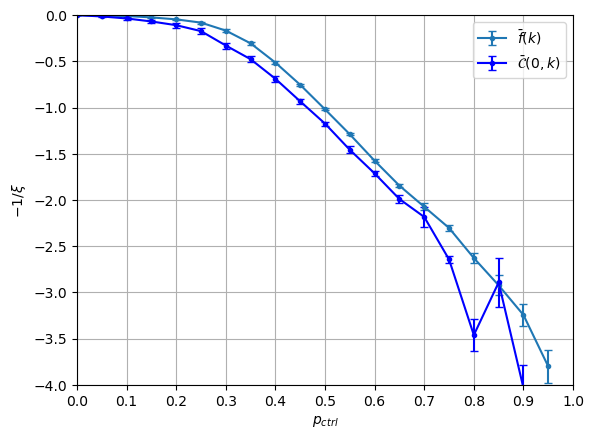

In [135]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)

ax.errorbar(p_ctrl_list[:len(beta_diag_list)],beta_diag_list,yerr=beta_error_diag_list,fmt='.-',capsize=3,label=r'$\bar{f}(k)$')

# ax.errorbar(p_ctrl_list[:len(beta_list)],beta_list,yerr=beta_error_list,fmt='.-',capsize=3,color='r',label=r'$C(0,k)$')

ax.errorbar(p_ctrl_list[:len(beta_C_list)],beta_C_list,yerr=alpha_error_C_list,fmt='.-',capsize=3,color='b',label=r'$\bar{\mathcal{C}}(0,k)$')

ax.legend()
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$-1/\xi$')
ax.set_xlim(0,1)
ax.set_ylim(-4,0)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

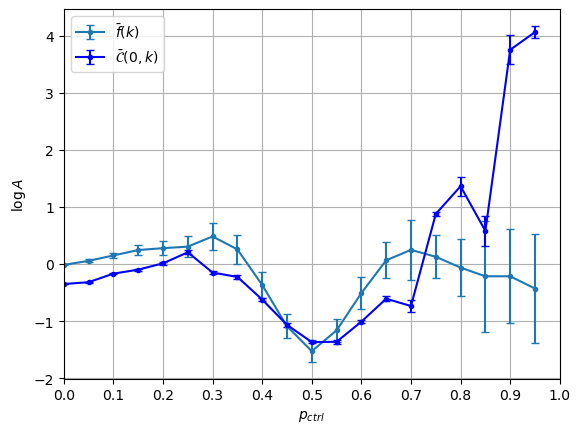

In [137]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)


ax.errorbar(p_ctrl_list[:len(A_diag_list)],A_diag_list,yerr=A_error_diag_list,fmt='.-',capsize=3,label=r'$\bar{f}(k)$')

# ax.errorbar(p_ctrl_list[:len(A_list)],A_list,yerr=A_error_list,fmt='.-',capsize=3,color='r',label=r'$C(0,k)$')

ax.errorbar(p_ctrl_list[:len(A_C_list)],A_C_list,yerr=alpha_error_C_list,fmt='.-',capsize=3,color='b',label=r'$\bar{\mathcal{C}}(0,k)$')

ax.legend()
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\log A$')
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

# Average in $L\rightarrow\infty$

In [4]:
dirpath='.'

In [5]:
f_T_s={}
L=8
for s in range(5):
    # f_T_s[s]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{s}_64_wf_T_all.hdf5'))
    f_T_s[s]=h5py.File(os.path.join(dirpath,f'CT_En20000_pctrl(0.50,0.75,2)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{s}_64_wf_T_all.hdf5'))


In [97]:
rho_av=get_rho_av_T_seed(f_T_s,L=8,i=0,T=128,seed_range=range(5))

In [98]:
rho_av.shape

torch.Size([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [99]:
get_reduced_dm(rho_av,internal_coherence=True)

array([[0.        , 0.00042676, 0.00055255, 0.00047758, 0.00044757,
        0.00052624, 0.00051469, 0.00051305, 0.00047165],
       [0.00042676, 0.        , 0.00067846, 0.0007592 , 0.00030692,
        0.00057733, 0.00044481, 0.00049449, 0.00045274],
       [0.00055255, 0.00067846, 0.00093161, 0.00074464, 0.00097387,
        0.00110291, 0.00110784, 0.00105161, 0.00086857],
       [0.00047758, 0.0007592 , 0.00074464, 0.00233201, 0.00199481,
        0.00222373, 0.0020725 , 0.00197413, 0.00183536],
       [0.00044757, 0.00030692, 0.00097387, 0.00199481, 0.00397344,
        0.00423543, 0.00409451, 0.00404418, 0.00349909],
       [0.00052624, 0.00057733, 0.00110291, 0.00222373, 0.00423543,
        0.00845921, 0.00764738, 0.00790279, 0.00689079],
       [0.00051469, 0.00044481, 0.00110784, 0.0020725 , 0.00409451,
        0.00764738, 0.01927623, 0.01579287, 0.01418424],
       [0.00051305, 0.00049449, 0.00105161, 0.00197413, 0.00404418,
        0.00790279, 0.01579287, 0.03740508, 0.02876236],


In [125]:
bootstrap_size_list=[100,500,1000,2000,]
# bootstrap_size_list=[1000,2000,4000,8000,16000,24000,32000,48000,60000,72000,80000,90000,100000]

T_list=range(20)
red_dm_list_map,red_dm_per_list_map=resample(f_T_s,L=8,T_list=T_list,i_list=[0],ensemble_size=20,bootstrap_size_list=bootstrap_size_list,seed_max=5,internal_coherence=True)

  0%|          | 0/4 [00:00<?, ?it/s]/home/hnpan/control_transition/coherence.py:201: RuntimeWarning: invalid value encountered in divide
  return rho/number_state_map
100%|██████████| 4/4 [09:52<00:00, 148.03s/it]


In [24]:
red_dm_per_list_map.mean(axis=1).shape

(3, 1, 1, 9, 9)

Text(0, 0.5, 'C(2,2)')

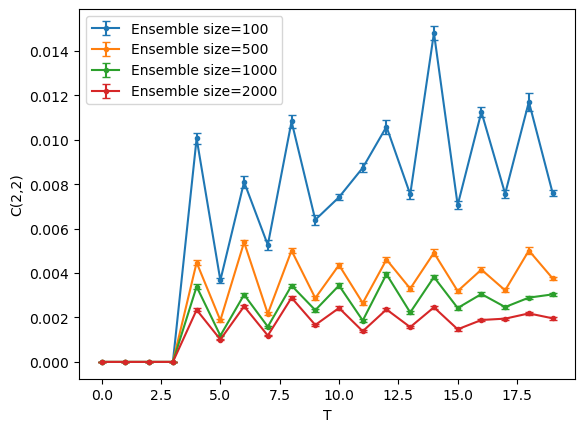

In [143]:
i,j=2,2
fig,ax=plt.subplots()
for bs in range(4):
    ax.errorbar(x=T_list,y=red_dm_per_list_map.mean(axis=1)[bs,0,:,i,j],yerr=red_dm_per_list_map.std(axis=1)[bs,0,:,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3,label=f'Ensemble size={bootstrap_size_list[bs]}')
ax.legend()

ax.set_xlabel('T')
ax.set_ylabel(f'C({i},{j})')

In [133]:
red_dm_per_list_map.shape

(4, 20, 1, 20, 9, 9)

Text(0, 0.5, 'C(2,2)')

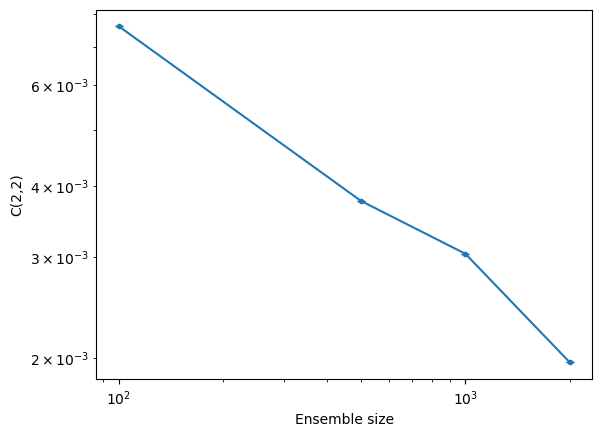

In [136]:
i,j=2,2
fig,ax=plt.subplots()
ax.errorbar(bootstrap_size_list,red_dm_per_list_map.mean(axis=1)[:,0,-1,i,j],yerr=red_dm_per_list_map.std(axis=1)[:,0,0,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Ensemble size')
ax.set_ylabel(f'C({i},{j})')

## Swap order of mean and coherence

In [ ]:
bootstrap_size_list=[10,]

%lprun -f get_rho_av_T_seed_swap red_dm_list_map,red_dm_per_list_map=resample(f_T_s,L=8,T_list=T_list,i_list=[0],ensemble_size=20,bootstrap_size_list=bootstrap_size_list,seed_max=5,internal_coherence=True,swap=True)

In [65]:
bootstrap_size_list=[100,500,1000,2000]
# bootstrap_size_list=[1000,2000,4000,8000,16000,24000,32000,48000,60000,72000,80000,90000,100000]

# T_list=[128]
T_list=range(20)
red_dm_list_map,red_dm_per_list_map=resample(f_T_s,L=8,T_list=T_list,i_list=[1],ensemble_size=20,bootstrap_size_list=bootstrap_size_list,seed_max=5,internal_coherence=True,swap=True)

  0%|          | 0/4 [00:00<?, ?it/s]/home/hnpan/control_transition/coherence.py:242: RuntimeWarning: invalid value encountered in divide
  return rho/number_state_map
100%|██████████| 4/4 [09:47<00:00, 146.78s/it]


In [7]:
bootstrap_size_list=[100,500,1000,2000]
T_list=range(129)

In [5]:
with open('rho_ave_8_all_swap.pickle','rb') as f:
# with open('rho_ave_8_all.pickle','rb') as f:
   [red_dm_list_map,red_dm_per_list_map]=pickle.load(f) 

In [5]:
red_dm_per_list_map.mean(axis=1).shape

(4, 2, 129, 9, 9)

In [6]:
red_dm_list_map.shape

(4, 20, 2, 129, 9, 9)

Text(0, 0.5, 'C(3,3)')

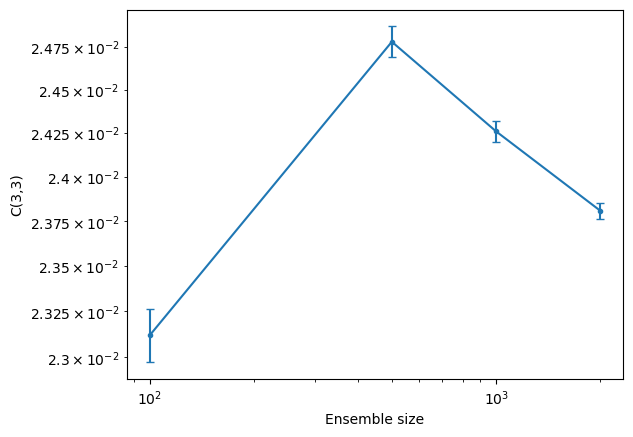

In [8]:
i,j=3,3
T_idx=128
fig,ax=plt.subplots()
ax.errorbar(bootstrap_size_list,red_dm_per_list_map.mean(axis=1)[:,0,T_idx,i,j],yerr=red_dm_per_list_map.std(axis=1)[:,0,T_idx,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Ensemble size')
ax.set_ylabel(f'C({i},{j})')

Text(0, 0.5, 'C(0,1)')

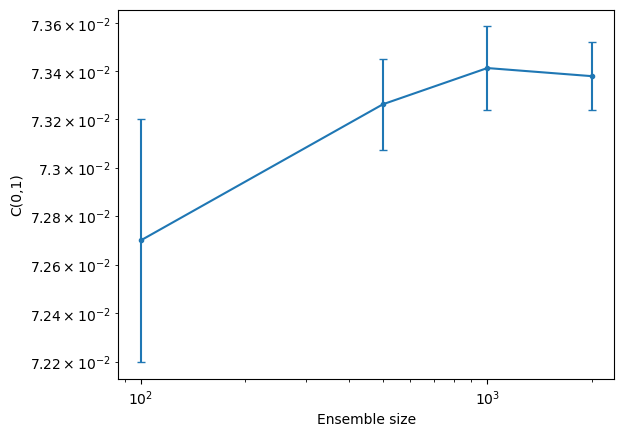

In [10]:
i,j=0,1
T_idx=128
fig,ax=plt.subplots()
ax.errorbar(bootstrap_size_list,red_dm_per_list_map.mean(axis=1)[:,0,T_idx,i,j],yerr=red_dm_per_list_map.std(axis=1)[:,0,T_idx,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Ensemble size')
ax.set_ylabel(f'C({i},{j})')

In [90]:
T_list=range(4,8)

Text(0, 0.5, 'C(0,1)')

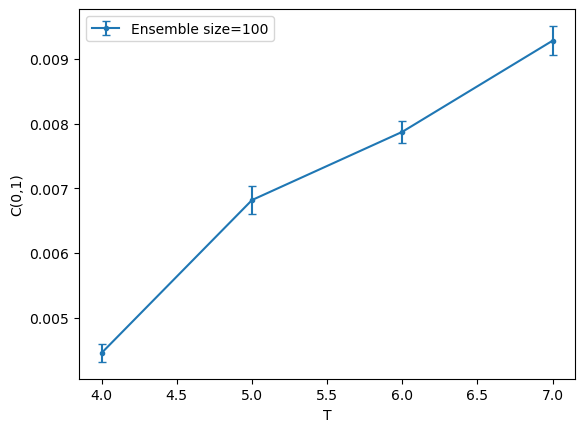

In [100]:
i,j=0,1
fig,ax=plt.subplots()
for bs in range(1):
    ax.errorbar(x=T_list,y=red_dm_per_list_map.mean(axis=1)[bs,0,:,i,j],yerr=red_dm_per_list_map.std(axis=1)[bs,0,:,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3,label=f'Ensemble size={bootstrap_size_list[bs]}')
ax.legend()

ax.set_xlabel('T')
ax.set_ylabel(f'C({i},{j})')

In [80]:
len(np.array(T_list)-tmin)

20

Text(0, 0.5, 'C(3,3)')

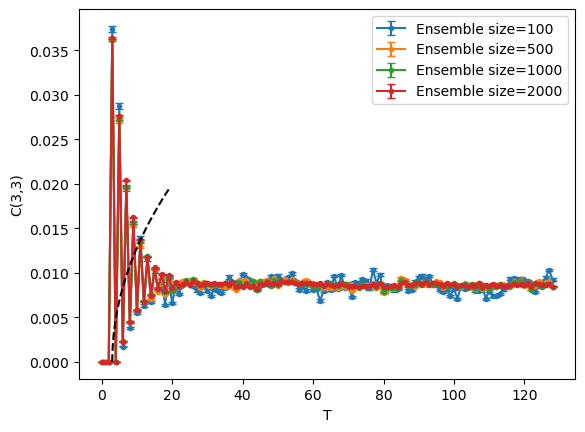

In [31]:
i,j=3,3
fig,ax=plt.subplots()
tmin,tmax=3,20
i_idx=1
for bs in range(4):
    ax.errorbar(x=(T_list),y=red_dm_per_list_map.mean(axis=1)[bs,i_idx,:,i,j],yerr=red_dm_per_list_map.std(axis=1)[bs,i_idx,:,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3,label=f'Ensemble size={bootstrap_size_list[bs]}')
ax.legend()


t_list_fine=np.linspace(0,(tmax-tmin-1)**(.5),101)**(1/.5)
f=lambda x: red_dm_per_list_map.mean(axis=1)[bs,i_idx,tmin+8,i,j]*(x/(8))**(.5)
ax.plot((t_list_fine)+tmin,f(t_list_fine),'--',color='k',zorder=10)

ax.set_xlabel('T')
ax.set_ylabel(f'C({i},{j})')

Text(0, 0.5, 'C(3,3)')

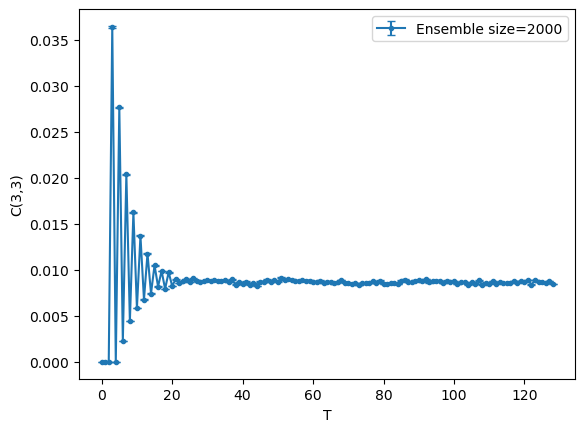

In [59]:
# i,j=3,3



# t_list_fine=np.linspace(0,(tmax-tmin-1)**(.5),101)**(1/.5)
# f=lambda x: red_dm_per_list_map.mean(axis=1)[bs,i_idx,tmin+8,i,j]*(x/(8))**(.5)
# ax.plot((t_list_fine)+tmin,f(t_list_fine),'--',color='k',zorder=10)

ax.set_xlabel('T')
ax.set_ylabel(f'C({i},{j})')

In [ ]:
ok still zero, this is a bit boring...

# Spread of wave packet (in DW basis)

In [86]:
dirpath='.'

In [87]:
L_list=[8,10]

In [88]:
f_T={}
for L in L_list:
    f_T[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf_T_all.hdf5'))

In [138]:
f_T[8].close()

In [131]:
f_T_s={}
L=8
for s in range(5):
    # f_T_s[s]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{s}_64_wf_T_all.hdf5'))
    f_T_s[s]=h5py.File(os.path.join(dirpath,f'CT_En20000_pctrl(0.50,0.75,2)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed{s}_64_wf_T_all.hdf5'))

In [130]:
[f_T_s[i].close() for i in range(4)]

[None, None, None, None]

In [ ]:
rho_av_0=get_rho_av_T(f_T,L=8,i=10,T=128,)

In [97]:
rho_av=get_rho_av_T_seed(f_T_s,L=8,i=0,T=128,seed_range=range(2))

In [35]:
rho_av=get_rho_av_T_seed(f_T_s,L=8,i=10,T=128,seed_range=range(8),bootstrap=20,rng=10)

In [ ]:
get_reduced_dm(rho_av)

In [219]:
rho_av[(0,)*15+(1,)].item()

0.0014110503613156374

In [190]:
rho_av_0[(0,)*15+(1,)]

tensor(0.0012, dtype=torch.float64)

In [48]:
rho_av.shape

torch.Size([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [45]:
red_dm_list, red_dm_per_list=save_reduced_dm_T_seed(f_T_s,8,seed_range=range(8),T_list=[128],i_list=[10],rng=0,save=False,bootstrap=100)

1it [00:00, 25.83it/s]


In [85]:
bootstrap_size_list=[100,200,500,1000,2000,4000,8000,16000]
red_dm_list_map,red_dm_per_list_map=resample(L=8,T_list=[128],i_list=[10],ensemble_size=20,bootstrap_size_list=bootstrap_size_list)

100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


In [147]:
bootstrap_size_list=[1000,2000,4000,8000,16000,24000,32000,48000,60000,72000,80000,90000,100000]
red_dm_list_map,red_dm_per_list_map=resample(L=8,T_list=[128],i_list=[1],ensemble_size=50,bootstrap_size_list=bootstrap_size_list,seed_max=5)

100%|██████████| 13/13 [04:46<00:00, 22.04s/it]


In [77]:
red_dm_list_map.shape

(2, 20, 1, 1, 9, 9)

In [125]:
red_dm_per_list_map.shape

(11, 20, 1, 1, 9, 9)

Text(0, 0.5, 'C(0,0)')

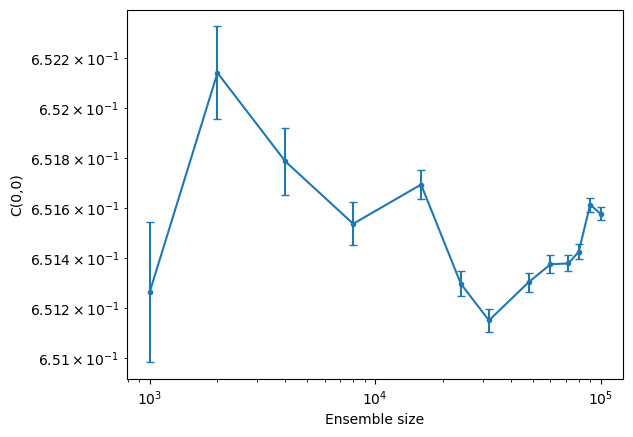

In [148]:
i,j=0,0
fig,ax=plt.subplots()
ax.errorbar(bootstrap_size_list,red_dm_per_list_map.mean(axis=1)[:,0,0,i,j],yerr=red_dm_per_list_map.std(axis=1)[:,0,0,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Ensemble size')
ax.set_ylabel(f'C({i},{j})')

Text(0, 0.5, 'C(0,1)')

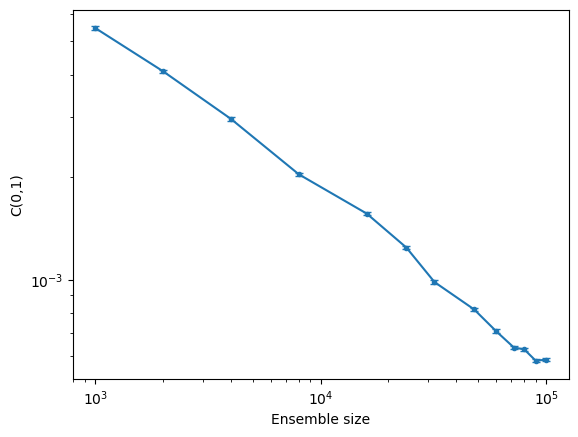

In [149]:
i,j=0,1
fig,ax=plt.subplots()
ax.errorbar(bootstrap_size_list,red_dm_per_list_map.mean(axis=1)[:,0,0,i,j],yerr=red_dm_per_list_map.std(axis=1)[:,0,0,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Ensemble size')
ax.set_ylabel(f'C({i},{j})')

Text(0, 0.5, 'C(1,1)')

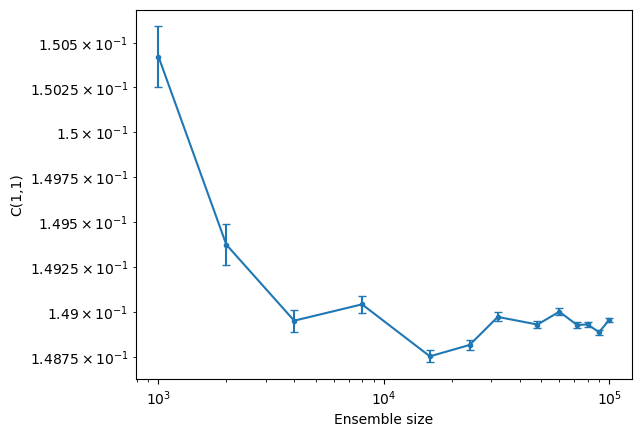

In [150]:
i,j=1,1
fig,ax=plt.subplots()
ax.errorbar(bootstrap_size_list,red_dm_per_list_map.mean(axis=1)[:,0,0,i,j],yerr=red_dm_per_list_map.std(axis=1)[:,0,0,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Ensemble size')
ax.set_ylabel(f'C({i},{j})')

Text(0, 0.5, 'C(1,2)')

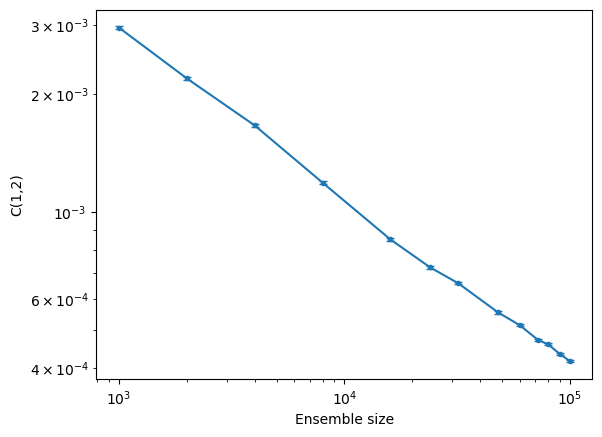

In [151]:
i,j=1,2
fig,ax=plt.subplots()
ax.errorbar(bootstrap_size_list,red_dm_per_list_map.mean(axis=1)[:,0,0,i,j],yerr=red_dm_per_list_map.std(axis=1)[:,0,0,i,j]/red_dm_per_list_map.shape[1],fmt='.-',capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Ensemble size')
ax.set_ylabel(f'C({i},{j})')

In [156]:
i,j=0,1
fit_res=linregress(
    np.log(bootstrap_size_list),
    np.log(red_dm_per_list_map.mean(axis=1)[:,0,0,i,j])
)

In [157]:
fit_res

LinregressResult(slope=-0.5061608299083683, intercept=-1.6500919768232771, rvalue=-0.9983953136352222, pvalue=4.522415989322522e-15, stderr=0.008656163274848071, intercept_stderr=0.08691237039722474)

In [46]:
red_dm_list.shape

(1, 1, 9, 9)

In [220]:
save_reduced_dm_T_seed(f_T_s,8,seed_range=range(8),)

100%|██████████| 21/21 [06:37<00:00, 18.93s/it]


In [157]:
(np.abs((f_T[8]['wf_8'][0,0,-1,...,:,0][...,0]))**2).sum()

1.0000035172535129

In [48]:
# save_reduced_dm_T(f_T,8)

100%|██████████| 21/21 [00:44<00:00,  2.11s/it]


In [55]:
# save_reduced_dm_T(f_T,10)

100%|██████████| 21/21 [05:37<00:00, 16.06s/it]


In [ ]:
save_reduced_dm_T(f_T_s,0)

In [66]:
rho_T_av[8]['red_dm'][0,10,:2,:2]

array([[3.81242371e-03, 6.60083634e-05],
       [6.60083634e-05, 3.89752888e-03]])

In [67]:
rho_T_av_all['red_dm'][0,10,:2,:2]

array([[15.51288053,  0.2478174 ],
       [ 0.2478174 , 15.57173678]])

In [61]:
rho_T_av={}
for L in L_list:
    with open(f'rho_T_av_{L}.pickle','rb') as f:
        rho_T_av[L]=pickle.load(f)

In [222]:
L=8
with open(f'rho_T_av_{L}_all.pickle','rb') as f:
    rho_T_av_all=pickle.load(f)

In [15]:
rho_T_av[8]['red_dm'].shape

(21, 129, 9, 9)

In [58]:
rho_T_av_all['red_dm'].shape

(1, 129, 9, 9)

In [85]:
# rho_T_diag=np.einsum(rho_T_av[10]['red_dm'],[0,1,2,2],[0,1,2])
rho_T_diag=np.einsum(rho_T_av_all['red_dm'],[0,1,2,2],[0,1,2])

In [59]:
rho_T_diag.shape

(1, 129, 9)

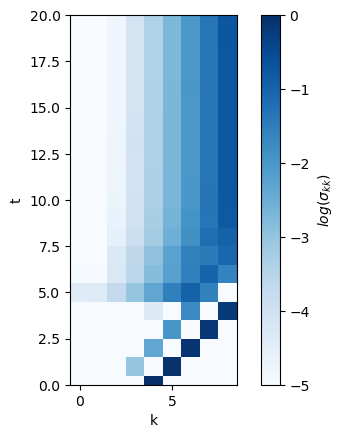

In [88]:
t=20
fig,ax=plt.subplots()
# im=ax.imshow(np.log(rho_T_diag[10]+1e-5),cmap='Blues',vmin=-5)
im=ax.imshow(np.log(rho_T_diag[1]+1e-5),cmap='Blues',vmin=-5)
ax.set_ylim(0,t)
ax.set_ylabel('t')
ax.set_xlabel('k')
plt.colorbar(im,label='$log(\sigma_{kk})$')

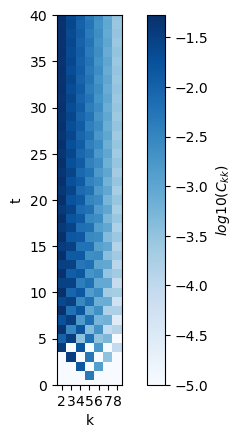

In [83]:
fig,ax=plt.subplots()
i_idx=0
bs=3
L=8

t=40
k_list=range(2,L+1)
t_list=range(129)

red_dm_diag=np.array([red_dm_per_list_map.mean(axis=1)[bs,i_idx,:,i,i] for i in k_list]).T
im=ax.pcolormesh(k_list,t_list,np.log10(red_dm_diag+1e-5),cmap='Blues',vmin=-5,)

ax.set_ylim(0,t)
ax.set_ylabel('t')
ax.set_xlabel('k')
ax.set_xticks(k_list)
plt.colorbar(im,label='$log10(C_{kk})$')
ax.set_aspect('equal')

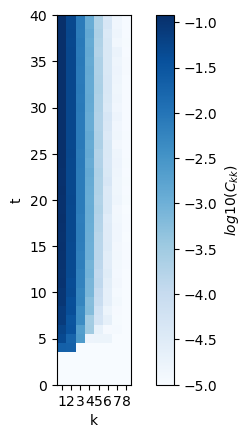

In [144]:
fig,ax=plt.subplots()
i_idx=1
bs=3
L=8

t=40
k_list=range(1,L+1)
t_list=range(129)

red_dm_offdiag=np.array([red_dm_per_list_map.mean(axis=1)[bs,i_idx,:,0,i] for i in k_list]).T
im=ax.pcolormesh(k_list,t_list,np.log10(red_dm_offdiag+1e-5),cmap='Blues',vmin=-5,)

ax.set_ylim(0,t)
ax.set_ylabel('t')
ax.set_xlabel('k')
ax.set_xticks(k_list)
plt.colorbar(im,label='$log10(C_{kk})$')
ax.set_aspect('equal')

Text(0, 0.5, 'C(0,0)')

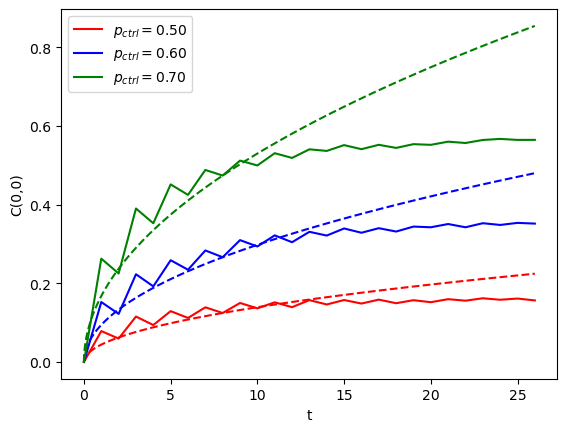

In [339]:
j=0
L=8
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
color_list=['r','b','g','pink']
tmin,tmax=3,30
for idx,color in zip([10,12,14],color_list):
    t_list=np.arange(tmin,tmax)
    # ax.plot((t_list-tmin),(rho_T_av[L]['red_dm_per'][idx,tmin:tmax,0,j]),label=f'$p_{{ctrl}}={p_ctrl_list[idx]:.2f}$',color=color)

    t_list_fine=np.linspace(0,(tmax-tmin-1)**(.5),101)**(1/.5)
    f=lambda x: rho_T_av_all['red_dm_per'][idx,tmin+8,0,j]*(x/(8))**(.5)
    ax.plot((t_list_fine),f(t_list_fine),'--',color=color,)

    ax.plot((t_list-tmin),(rho_T_av_all['red_dm_per'][idx,tmin:tmax,0,j]),label=f'$p_{{ctrl}}={p_ctrl_list[idx]:.2f}$',color=color)
    # ax.plot(np.log(t_list-tmin+1), np.log(t_list-tmin+1) * fit_res.slope + fit_res.intercept)
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel(f'C(0,{j})')
# ax.plot(rho_T_av[10]['red_dm_per'][idx,:,0,1])

In [153]:
from scipy.stats import linregress


In [326]:
fit_res=linregress(
    np.log(t_list-tmin+1)[1:],
    np.log(rho_T_av_all['red_dm_per'][idx,tmin:tmax,0,j])[1:]
    )

/tmp/ipykernel_26820/2025545861.py:3: RuntimeWarning: divide by zero encountered in log
  np.log(rho_T_av_all['red_dm_per'][idx,tmin:tmax,0,j])[1:]


In [329]:
fit_res.intercept

-2.89071549967476

In [327]:
fit_res.slope

0.38119713505676056

Text(0, 0.5, 'C(0,1)')

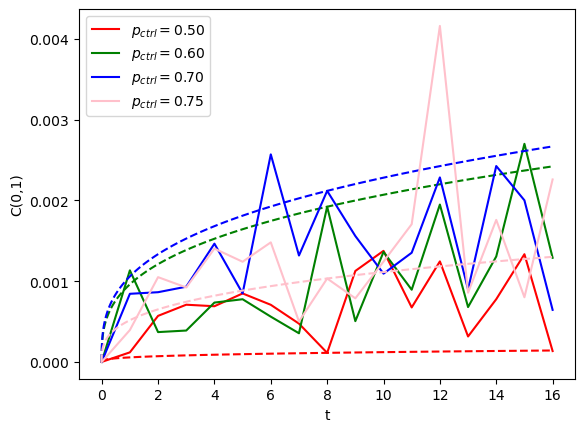

In [300]:
j=1
L=8
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
color_list=['r','g','b','pink']
tmin,tmax=3,20
for idx,color in zip([10,12,14,15,18],color_list):
    t_list=np.arange(tmin,tmax)
    # ax.plot((t_list-tmin),(rho_T_av[L]['red_dm_per'][idx,tmin:tmax,0,j]),label=f'$p_{{ctrl}}={p_ctrl_list[idx]:.2f}$',color=color)

    t_list_fine=np.linspace(0,(tmax-tmin-1)**(1/3),101)**3
    f=lambda x: rho_T_av_all['red_dm_per'][idx,tmin+8,0,j]*(x/(8))**(1/3)
    ax.plot((t_list_fine),f(t_list_fine),'--',color=color,)

    ax.plot((t_list-tmin),(rho_T_av_all['red_dm_per'][idx,tmin:tmax,0,j]),label=f'$p_{{ctrl}}={p_ctrl_list[idx]:.2f}$',color=color)
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel(f'C(0,{j})')
# ax.plot(rho_T_av[10]['red_dm_per'][idx,:,0,1])

In [299]:
rho_T_av[L]['red_dm_per'][15,3+8,0,1]

0.005277289973658961

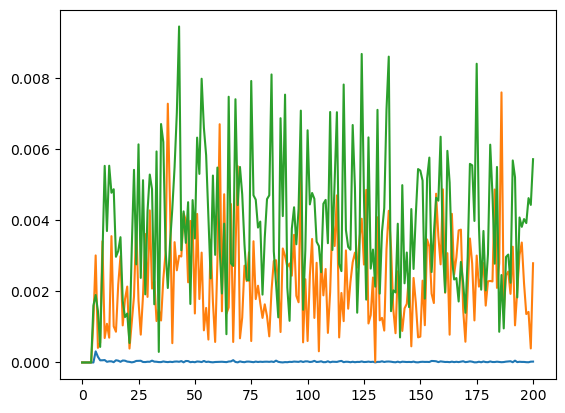

In [152]:
plt.plot(rho_T_av[10]['red_dm_per'][0,:,0,1])
plt.plot(rho_T_av[10]['red_dm_per'][10,:,0,1])
plt.plot(rho_T_av[10]['red_dm_per'][15,:,0,1])


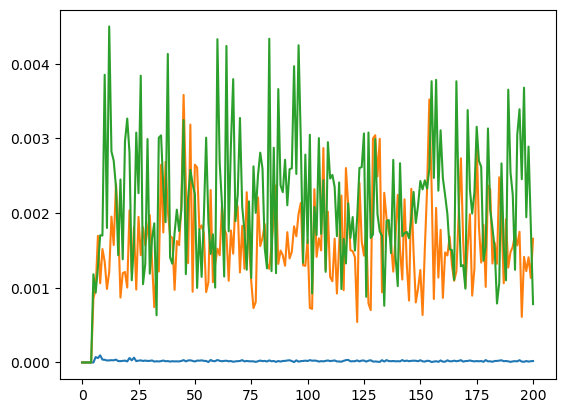

In [161]:
plt.plot(rho_T_av[10]['red_dm_per'][0,:,0,2])
plt.plot(rho_T_av[10]['red_dm_per'][10,:,0,2])
plt.plot(rho_T_av[10]['red_dm_per'][15,:,0,2])


In [ ]:
This larger fluctuation? 
is this because a mistake 
or finite size effect?
undersampling?

or is there some random phase?? [no, density matrix is U(1) gauge invariant]

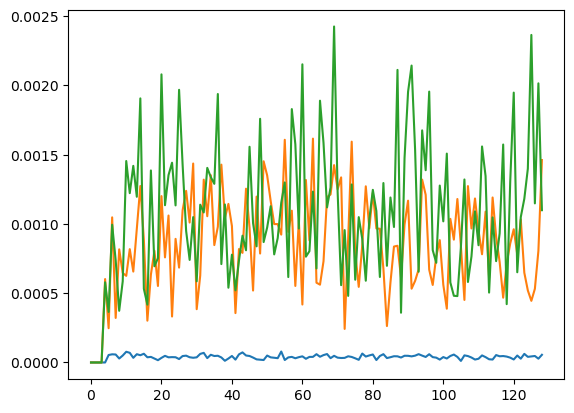

In [107]:
plt.plot(rho_T_av_all['red_dm_per'][0,:,0,2])
plt.plot(rho_T_av_all['red_dm_per'][10,:,0,2])
plt.plot(rho_T_av_all['red_dm_per'][15,:,0,2])
# plt.xlim(0,50)

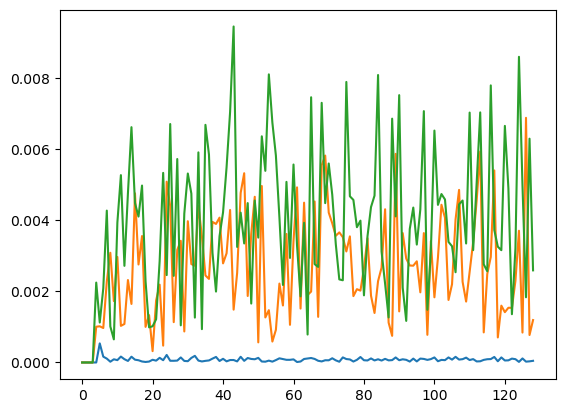

In [96]:
plt.plot(rho_T_av[8]['red_dm_per'][0,:,0,1])
plt.plot(rho_T_av[8]['red_dm_per'][10,:,0,1])
plt.plot(rho_T_av[8]['red_dm_per'][15,:,0,1])
# plt.xlim(0,20)

In [ ]:
j=3
L=8
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
color_list=['r','g','b','pink']
tmin,tmax=0,2*L**2
for idx,color in zip([0,5,10,15],color_list):
    t_list=np.arange(tmin,tmax)
    # ax.plot(np.log(t_list),(rho_T_av[L]['red_dm_per'][idx,tmin:tmax,0,j]),label=f'$p_{{ctrl}}={p_ctrl_list[idx]}$',color=color)
    ax.plot((t_list),(rho_T_av_all['red_dm_per'][idx,tmin:tmax,0,j]),label=f'$p_{{ctrl}}={p_ctrl_list[idx]}$',color=color)
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel(f'C(0,{j})')
# ax.plot(rho_T_av[10]['red_dm_per'][idx,:,0,1])

Text(0, 0.5, 'C(0,1)')

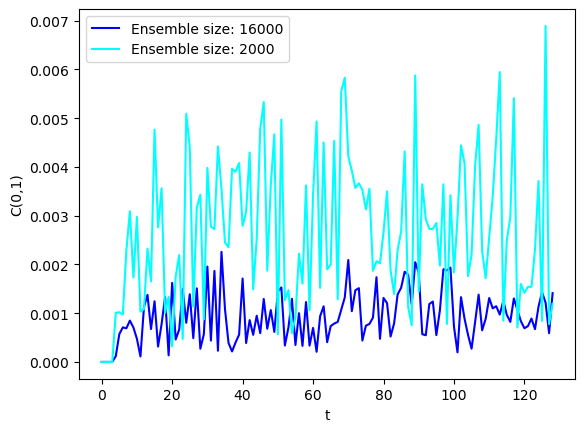

In [313]:
idx=10
j=1
fig,ax=plt.subplots()
ax.plot(rho_T_av_all['red_dm_per'][idx,:,0,j],label='Ensemble size: 16000',color='blue')
ax.plot(rho_T_av[8]['red_dm_per'][idx,:,0,j],label='Ensemble size: 2000',color='cyan')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel(f'C(0,{j})')

In [314]:
rho_T_av_all['red_dm_per'][idx,L:L*2,0,j].mean()

0.0007565899539920439

In [315]:
rho_T_av[8]['red_dm_per'][idx,L:L*2,0,j].mean()

0.002248431903492596

In [207]:
L=8
rr=[get_rho_av_T(f_T,L=L,i=0,T=T,s=0) for T in range(129)]

In [190]:
rr[-1][(0,)*8+(0,)*7+(1,)]

tensor(-0.0002-0.0012j, dtype=torch.complex128)

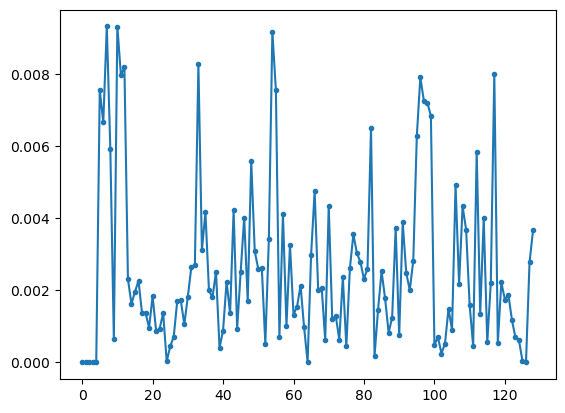

In [209]:
# plt.plot([rr[T][(0,)*8+(0,)*7+(1,)].real for T in range(0,129)])
# plt.plot([rr[T][(0,)*8+(0,)*7+(1,)].imag for T in range(0,129)])
plt.plot([torch.abs(rr[T][(0,)*8+(0,)*7+(1,)]) for T in range(0,129)],'.-')

In [ ]:
why is this so larger fluctuation?

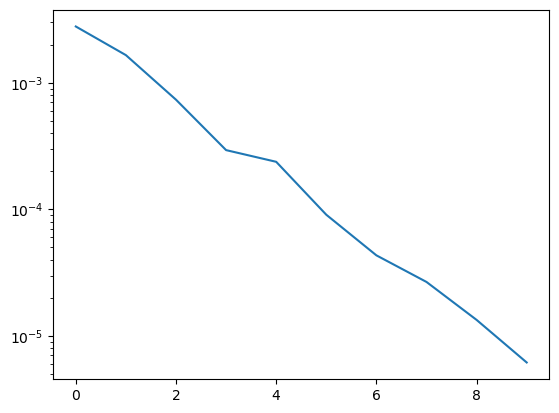

In [148]:
plt.plot(rho_T_av[10]['red_dm_per'][10,-1,0,1:])
plt.yscale('log')

/tmp/ipykernel_288210/1938319656.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(rho_T_av[8]['red_dm_per'][15,-1]),cmap='Blues')


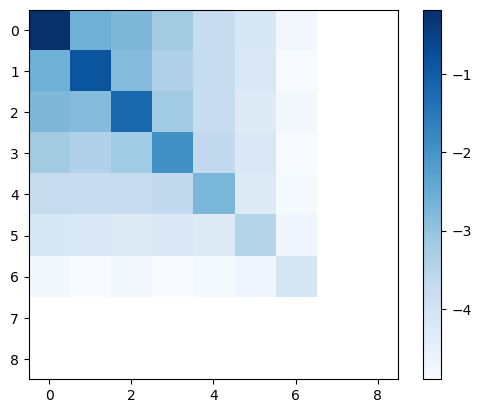

In [136]:
plt.imshow(np.log10(rho_T_av[8]['red_dm_per'][15,-1]),cmap='Blues')
plt.colorbar()

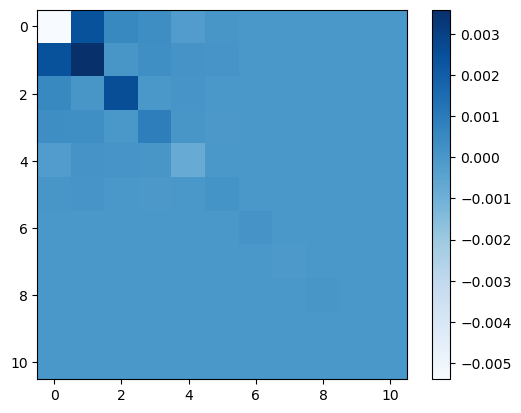

In [147]:
plt.imshow((rho_T_av[10]['red_dm_per'][10,-1]-rho_T_av[10]['red_dm_per'][10,-2]),cmap='Blues')
plt.colorbar()

In [184]:
rho_T_per=np.array([get_reduced_dm_per_basis(rho) for rho in rho_T])

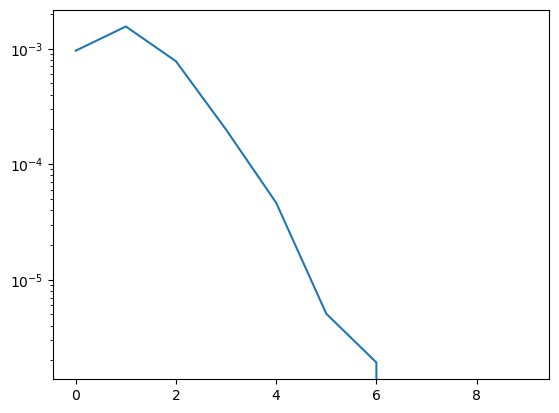

In [185]:
plt.plot(rho_T_per[187,0,1:])
plt.yscale('log')

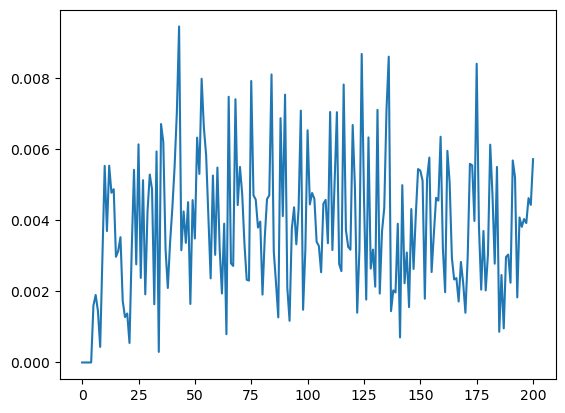

In [186]:
plt.plot(rho_T_per[:,0,1])

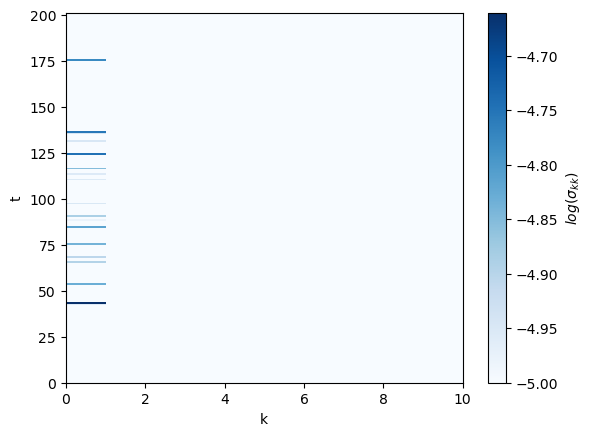

In [187]:
t=201
fig,ax=plt.subplots()
im=ax.pcolormesh(np.log(rho_T_per[:,0,1:]+1e-5),cmap='Blues',vmin=-5)
ax.set_ylim(0,t)
ax.set_ylabel('t')
ax.set_xlabel('k')
plt.colorbar(im,label='$log(\sigma_{kk})$')

In [69]:
rho_diag[6]

array([0.0078181 , 0.00782172, 0.01584085, 0.03215851, 0.0613126 ,
       0.12975232, 0.24992275, 0.49537325, 0.        ])

In [46]:
L_list_k

{1: [8, 10, 12, 14, 16],
 2: [8, 10, 12, 14, 16],
 3: [8, 10, 12, 14, 16],
 4: [8, 10, 12, 14, 16],
 5: [8, 10, 12, 14, 16],
 6: [8, 10, 12, 14, 16],
 7: [8, 10, 12, 14, 16],
 8: [8, 10, 12, 14, 16],
 9: [10, 12, 14, 16],
 10: [10, 12, 14, 16],
 11: [12, 14, 16],
 12: [12, 14, 16],
 13: [14, 16],
 14: [14, 16],
 15: [16]}

In [29]:
C_list_k

{1: [0.0001014375576271923,
  1.5372278657255204e-05,
  8.74518892962681e-06,
  1.2468850017422317e-06,
  2.6016473530358407e-07],
 2: [4.1461930937973094e-05,
  2.229900662654719e-05,
  3.882851043166184e-06,
  9.460973340649982e-07,
  2.34619921757807e-07],
 3: [0.0001092518724660655,
  1.575064934135284e-05,
  4.185446628838931e-06,
  1.1439006466601082e-06,
  1.5059828298762385e-07],
 4: [8.694676117497654e-05,
  2.180974528666167e-05,
  4.597001921292447e-06,
  1.6254069299631878e-06,
  4.804093157501973e-07],
 5: [8.000548122580502e-05,
  1.961125431172607e-05,
  5.151117564603396e-06,
  1.0843429814437376e-06,
  2.644243587323471e-07],
 6: [7.08501057534389e-05,
  2.0773486251119718e-05,
  4.939085609219586e-06,
  1.1015791539525591e-06,
  3.549185982482388e-07],
 7: [8.6659687041884e-05,
  1.9094849761406152e-05,
  4.791235694796206e-06,
  1.1168592494964182e-06,
  2.921291199889824e-07],
 8: [7.860385363562394e-05,
  1.8658656732254638e-05,
  4.62177684077718e-06,
  1.19831826

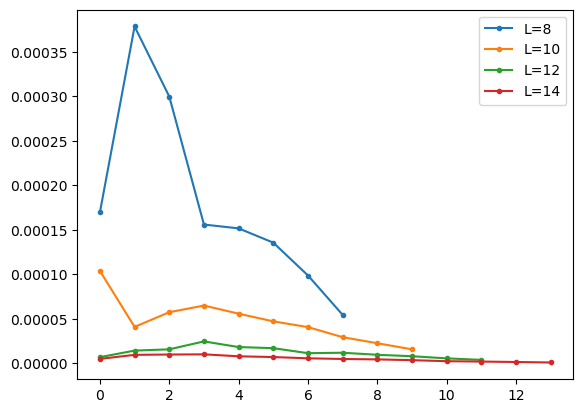

In [27]:
for L in [8,10,12,14]:
    plt.plot(rho_av[L]['red_dm_per'][5][0,1:],'.-',label=f'L={L}',)
plt.legend()

In [ ]:
for L in [8,10,12,14]:
    plt.plot([red_dm_per[L][i,i+1] for i in range(L)],'.-',label=f'L={L}')

/tmp/ipykernel_4182577/1813485167.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')


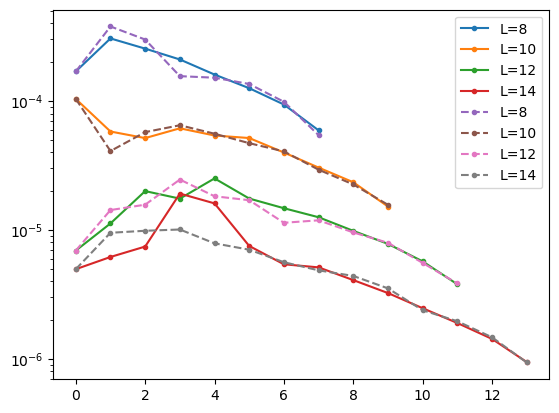

In [88]:
for L in [8,10,12,14]:
    plt.plot([red_dm_per[L][i,i+1] for i in range(L)],'.-',label=f'L={L}')
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')
plt.legend()
plt.yscale('log')   
# plt.xscale('log')   

/tmp/ipykernel_4182577/1033578318.py:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(red_dm_per[L][4,:4],'.-',label=f'L={L}',ls='dashed')


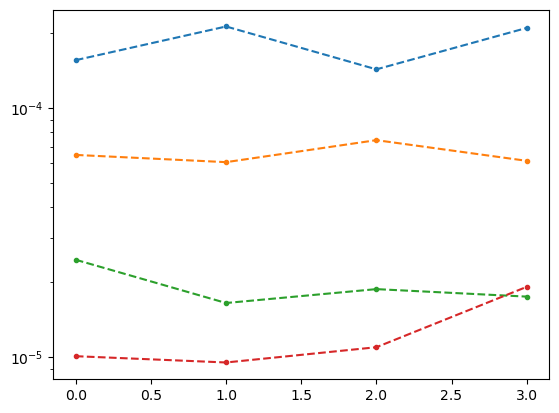

In [92]:
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][4,:4],'.-',label=f'L={L}',ls='dashed')
plt.yscale('log')

/tmp/ipykernel_4182577/2565562905.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')


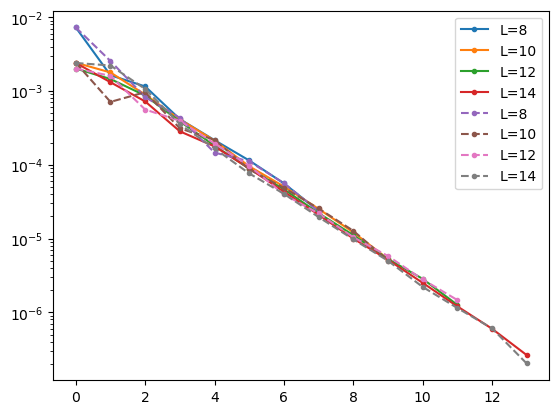

In [80]:
for L in [8,10,12,14]:
    plt.plot([red_dm_per[L][i,i+1] for i in range(L)],'.-',label=f'L={L}')
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')
# plt.plot(red_dm_per[0,1:],'.-')
plt.legend()
plt.yscale('log')   
# plt.xscale('log')   

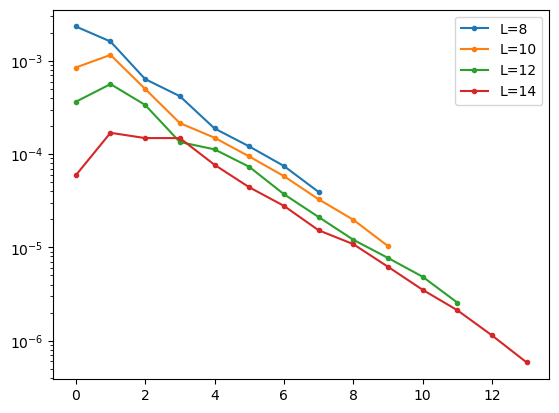

In [60]:
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}')
# plt.plot(red_dm_per[0,1:],'.-')
plt.yscale('log')
plt.legend()

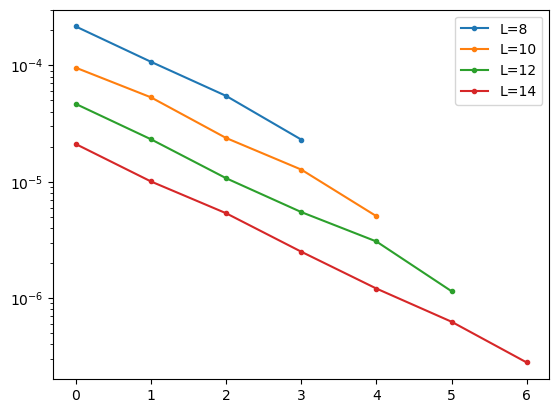

In [36]:
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][L//2,L//2+1:],'.-',label=f'L={L}')
# plt.plot(red_dm_per[0,1:],'.-')
plt.yscale('log')
plt.legend()

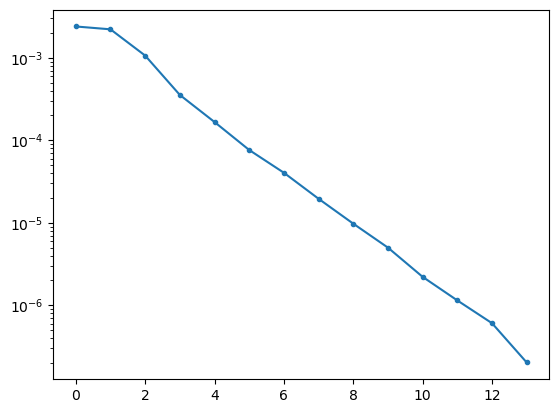

In [306]:
plt.plot(red_dm_per[0,1:],'.-')
plt.yscale('log')

# Coherence within FDW

In [10]:
red_dm=get_rho_av(f_0,8,10)

In [11]:
red_dm.shape

torch.Size([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
l1_coherence_2(red_dm,2,2)

tensor([[0.0636, 0.0028],
        [0.0028, 0.0653]], dtype=torch.float64)

In [35]:
l1_coherence_2(red_dm,2,2,internal_coherence=True)

tensor(0.0056, dtype=torch.float64)

In [36]:
l1_coherence_2(red_dm,3,3,internal_coherence=True)

tensor(0.0110, dtype=torch.float64)

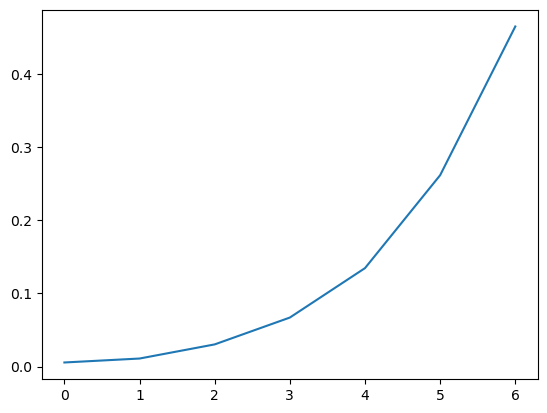

In [39]:
plt.plot([l1_coherence_2(red_dm,i,i,internal_coherence=True) for i in range(2,9)])

In [27]:
z=l1_coherence_2(red_dm,3,3)

In [33]:
z

tensor(0.1237, dtype=torch.float64)

In [23]:
z[0,0,0,0]+z[0,1,0,1]+z[1,0,1,0]+z[1,1,1,1]

tensor(0.1237, dtype=torch.float64)

In [21]:
trace(z)

tensor(0.1237, dtype=torch.float64)

# Plot reduced density matrix for coherence within FDW

In [82]:
rho_av_internal={}
L_list=[8,10,12,14,16]
for L in L_list:
    with open(f'rho_av_{L}_internal.pickle','rb') as f:
        rho_av_internal[L]=pickle.load(f)

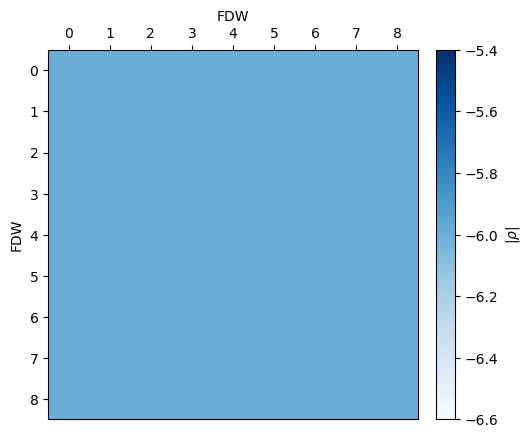

In [85]:
plot_reduced_dm(rho_av_internal[8]['red_dm'][20])

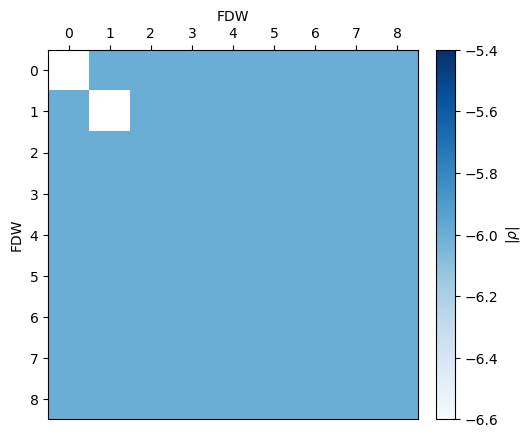

In [91]:
plot_reduced_dm(rho_av_internal[8]['red_dm_per'][20])

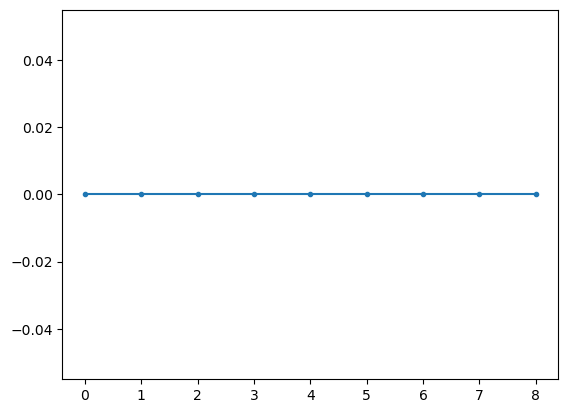

In [87]:
plt.plot(np.diag(rho_av_internal[8]['red_dm'][20]),'.-')

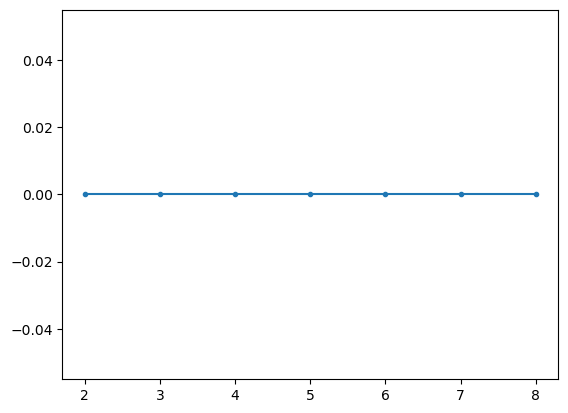

In [89]:
plt.plot(np.diag(rho_av_internal[8]['red_dm_per'][20]),'.-')

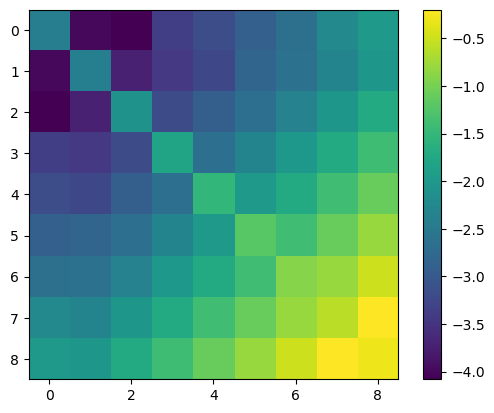

In [93]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

In [ ]:
plt.imshow(np.log10(red_dm_per))
plt.colorbar()

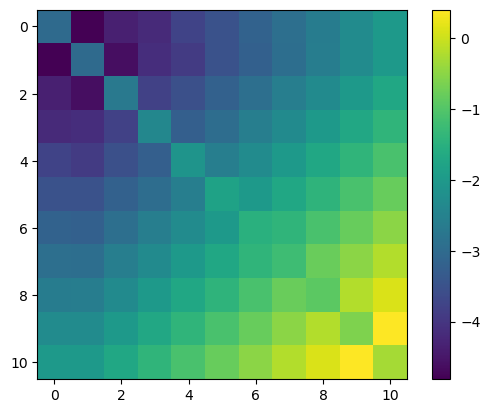

In [ ]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

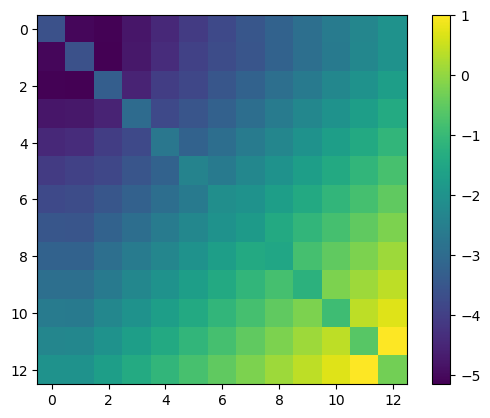

In [57]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

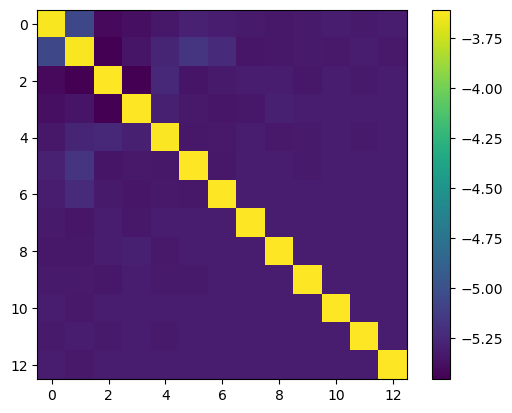

In [82]:
plt.imshow(np.log10(red_dm_per))
plt.colorbar()

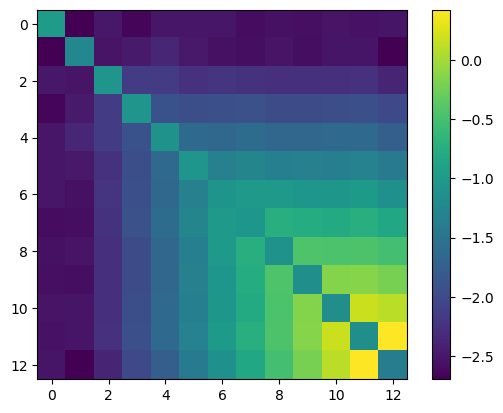

In [86]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

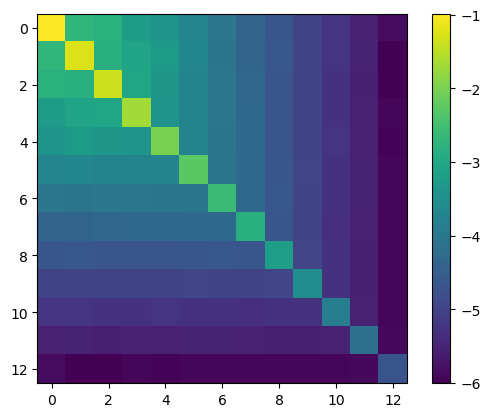

In [87]:
plt.imshow(np.log10(red_dm_per))
plt.colorbar()

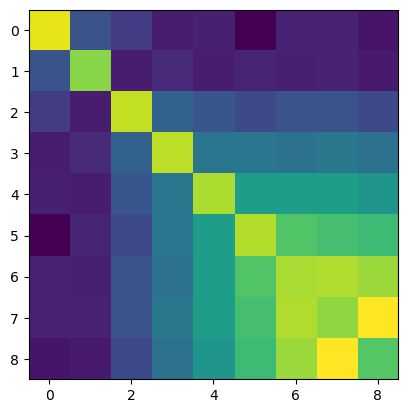

In [40]:
plt.imshow(np.log10(red_dm))

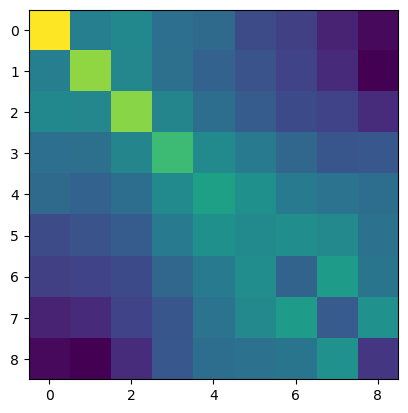

In [44]:
plt.imshow(np.log10(red_dm))

In [22]:
l1_coherence_2(rho_av,0,1)

0.00010143755762719205

In [13]:
l1_coherence_2(rho_av,1,1)

0.003915372962018893

In [14]:
l1_coherence_2(rho_av,0,1,)

0.00010143755762719205

In [15]:
rho_av.reshape((2**1,2**1))[:4,:4]

ValueError: cannot reshape array of size 65536 into shape (4096,4096)

In [14]:
sys.getsizeof(rho_av)/2**10/2**10

128.00045776367188

In [16]:
l1_coherence_2(rho_av,0,0)

0.0038090870155051016

In [17]:
l1_coherence_2(rho_av,1,1)

0.003915372962018893

In [18]:
l1_coherence_2(rho_av,0,1)

0.00010143755762719205

In [19]:
l1_coherence_2(rho_av,1,2)

0.00018960059500231185

In [43]:
L=10
list(range(L))+[2*L]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20]

In [83]:
with open('C_av_8.pickle','rb') as f:
    z=pickle.load(f)

In [84]:
z['red_dm'].shape

(21, 9, 9)

In [77]:
with open('C_av_8_tt.pickle','rb') as f:
    zz=pickle.load(f)

In [79]:
zz['red_dm'].shape

(21, 9, 9)

In [18]:
(2**14)**2*8/2**20

2048.0

In [41]:
(2**18)**2*16/2**30

1024.0

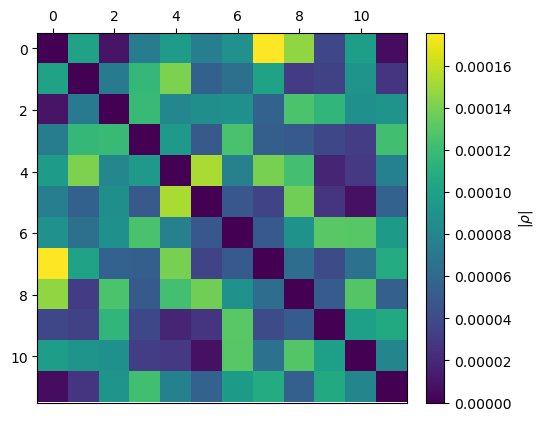

In [14]:
plot_coherence(rho_av,diag=False)

In [15]:
def l1_coherence_all(f_0,L,i,normalization=False,average=True):
    # wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
    # dm_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]

    rho_av=get_rho_av(f_0,L,i)
    
    return [l1_coherence(rho_av,k,normalization=normalization,average=average) for k in range(L)]

In [54]:
l1_coherence_all(f_0,L=8,i=0,normalization=True)

[0.013131993423792317,
 0.016200700609301462,
 0.027189298844675493,
 0.045647250896196916,
 0.1082025774614713,
 0.22065050694901078,
 0.4268802372429756,
 0.8443569274743464]

In [28]:
coh_map8=[l1_coherence_all(f_0,L=8,i=i,normalization=False,average=True) for i in range(21)]

In [25]:
coh_map10=[l1_coherence_all(f_0,L=10,i=i,normalization=False,average=True) for i in range(21)]

In [21]:
coh_map12=[]
for i in tqdm(range(21)):
    coh_map12.append(l1_coherence_all(f_0,L=12,i=i,normalization=False,average=True))
coh_map12=np.array(coh_map12)


100%|██████████| 21/21 [09:50<00:00, 28.12s/it]


In [35]:
coh_map8_raw=[l1_coherence_all(f_0,L=8,i=i,normalization=False,average=False) for i in range(21)]

In [ ]:
%lprun -f get_rho_av l1_coherence_all(f_0,L=12,i=0,normalization=False,average=True)

In [23]:
%lprun -f get_rho_av l1_coherence_all(f_0,L=14,i=0,normalization=False,average=True)

Timer unit: 1e-09 s

Total time: 448.278 s
File: /tmp/ipykernel_4158687/1750786917.py
Function: get_rho_av at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_rho_av(f_0,L,i):
     2         1  547838140.0 547838140.0      0.1      wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
     3         1 447730345438.0 447730345438.0     99.9      rho_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]
     4         1        471.0    471.0      0.0      return rho_av

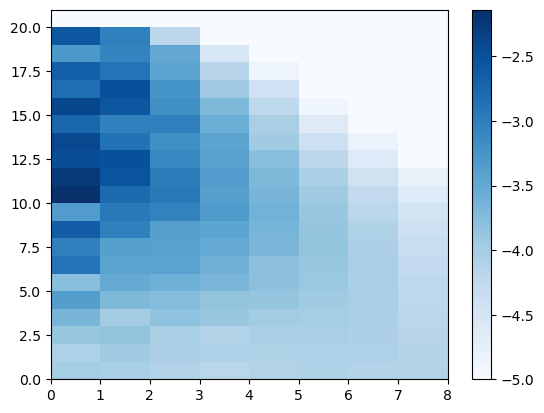

In [34]:
plt.pcolormesh(np.log10(np.array(coh_map8)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

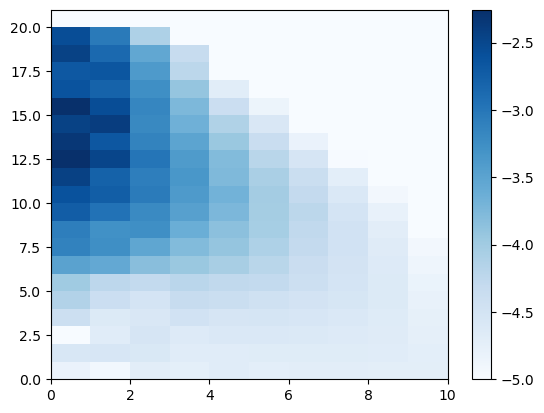

In [33]:
plt.pcolormesh(np.log10(np.array(coh_map10)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

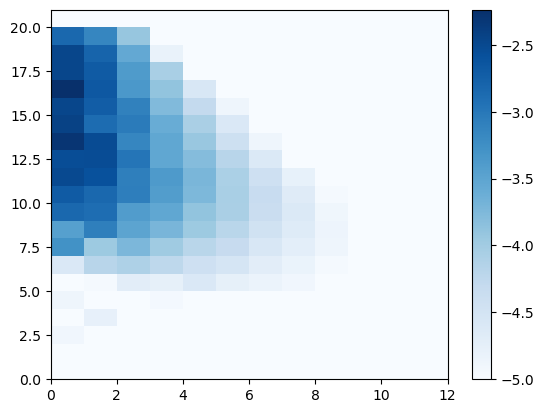

In [32]:
plt.pcolormesh(np.log10(np.array(coh_map12)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

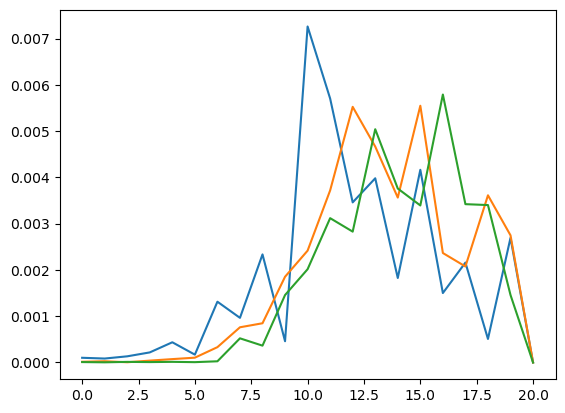

In [30]:
plt.plot(np.array(coh_map8)[:,0])
plt.plot(np.array(coh_map10)[:,0])
plt.plot(np.array(coh_map12)[:,0])

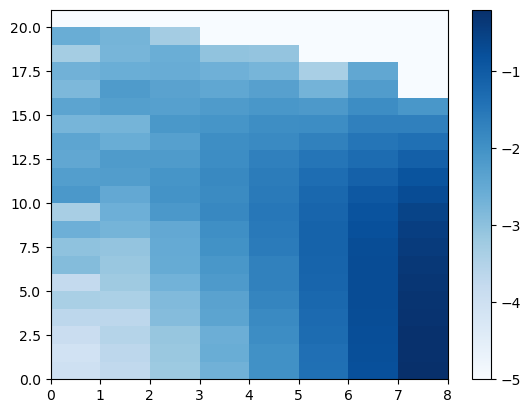

In [38]:
plt.pcolormesh(np.log10(np.array(coh_map8_raw)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

In [182]:
x=np.random.randn(10000,100)+5
y=np.random.randn(10000,100)+5
w=np.random.randn(10000,100)+5
v=np.random.randn(10000,100)+5

In [183]:
((x+1j*y)*(x-1j*y)).mean(axis=-1)

array([50.33078124+0.j, 53.73927441+0.j, 50.77307718+0.j, ...,
       54.13143732+0.j, 50.54294333+0.j, 52.59878581+0.j])

In [198]:
((x+1j*y)*(x-1j*y)).mean(axis=-1).std()

1.4291104582383554

In [199]:
np.abs(((w+1j*v)*(x-1j*y)).mean(axis=-1)).std()

1.007283683337483

/home/hnpan/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/hnpan/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


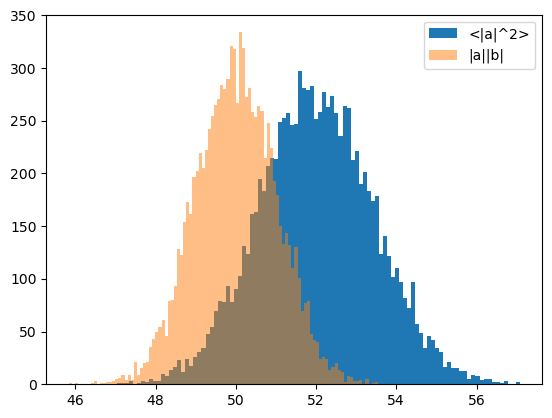

In [188]:
plt.hist(((x+1j*y)*(x-1j*y)).mean(axis=-1),bins=100,label='<|a|^2>',)
plt.hist(np.abs(((w+1j*v)*(x-1j*y)).mean(axis=-1)),bins=100,label='|a||b|',alpha=0.5)
plt.legend()

In [ ]:
plt.hist(np.abs((w+1j*v)*(x-1j*y)),bins=100)